<h3 align="center">National AI Student Challenge 2024</h3> 
<h3 align="center">Objective: To predict Adoption Rate and better understand the Adopter’s Preferences.</h3> 

<h4 align='center'>Completed by: Shi Yong Ni</h3>

### Import Libraries 

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import f_oneway, ttest_ind
import unicodedata
import re
from textblob import TextBlob
from googletrans import Translator
from wordcloud import WordCloud
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from timeit import default_timer as timer
import os

### Read the Data

In [2]:
#Load Data
current_dir = os.getcwd()
pet_train = pd.read_csv(current_dir+'\src\DataSets\pets_prepared.csv')
breed_labels = pd.read_csv(current_dir+r'\src\DataSets\breed_labels.csv')   
color_labels = pd.read_csv(current_dir+r'\src\DataSets\color_labels.csv') 
state_labels = pd.read_csv(current_dir+r'\src\DataSets\state_labels.csv') 

#Size of Data
print("Pet Train shape:", pet_train.shape,"|", "Total Entries:", pet_train.shape[0], "|","Total attributes:", pet_train.shape[1])
print("Breed label shape:", breed_labels.shape,"|", "Total breed:", breed_labels.shape[0])
print("Color label shape:", color_labels.shape,"|", "Total colors:",color_labels.shape[0])
print("State label shape:", state_labels.shape,"|", "Total state:", state_labels.shape[0])

Pet Train shape: (14993, 49) | Total Entries: 14993 | Total attributes: 49
Breed label shape: (307, 3) | Total breed: 307
Color label shape: (7, 2) | Total colors: 7
State label shape: (15, 2) | Total state: 15


In [3]:
#Look at all the columns in the train data set
print(pet_train.columns.tolist())

['PetID', 'AdoptionSpeed', 'Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID', 'VideoAmt', 'PhotoAmt', 'Description', 'AgeBins', 'FeeBins', 'BreedBins', 'StateBins', 'VideoAmtBins', 'PhotoAmtBins', 'QuantityBins', 'BreedPure', 'ColorAmt', 'NameorNO', 'Adopted', 'TypeName', 'GenderName', 'MaturitySizeName', 'FurLengthName', 'HealthName', 'VaccinatedName', 'DewormedName', 'SterilizedName', 'BreedName', 'BreedBinsName', 'StateName', 'StateBinsName', 'ColorName', 'AdoptedName']


### Target Variable (Adoption Rate)

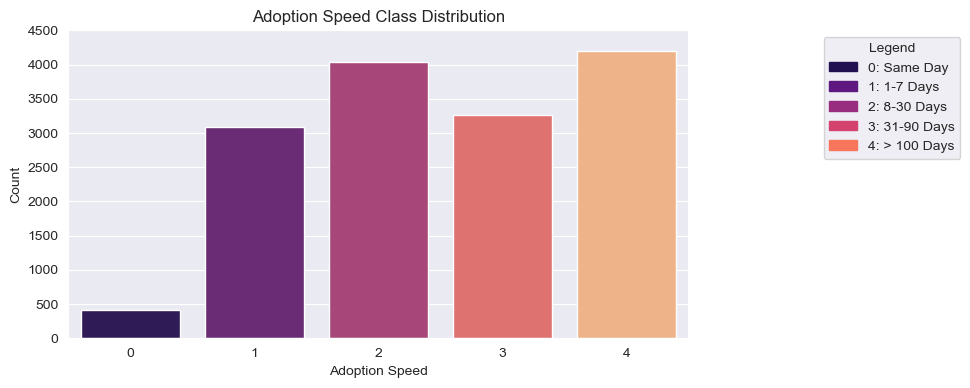

In [4]:
#Fig size
plt.figure(figsize=(8, 4))

# Set style
sns.set_style('darkgrid')

# Draw a countplot for AdoptionSpeed
ax = sns.countplot(x='AdoptionSpeed', data=pet_train, palette='magma')

# Set title and labels
plt.title("Adoption Speed Class Distribution")
plt.xlabel("Adoption Speed")
plt.ylabel("Count")
plt.yticks(range(0, 4501, 500)) 

# Define the legend labels
legend_labels = {
    0: 'Same Day',
    1: '1-7 Days',
    2: '8-30 Days',
    3: '31-90 Days',
    4: '> 100 Days'
}

# Add legend handles and labels
handles = [plt.Rectangle((0,0),1,1, color=sns.color_palette('magma')[i]) for i in range(len(legend_labels))]
labels = [f"{key}: {value}" for key, value in legend_labels.items()]

# Add legend
plt.legend(handles, labels, title='Legend', loc='upper right', bbox_to_anchor=(1.45, 1))
#plt.legend(handles, labels, title='Legend', loc='upper left', bbox_to_anchor=(-0.1, 1))
# Show plot
plt.show()

The distribution of adoption rates reveals a promising trend, with most pets finding homes within 8-30 days. However, a concerning proportion remains unadopted even after 100 days. This may signal issues such as mismatches between pets and potential adopters, health or behavioral concerns, or other factors that deter adoption. Understanding and addressing these challenges are crucial for ensuring successful placements and improving the overall adoption process.

### Check For Data Integrity

<h3 align='Center'>Missing Values</h3>

In [5]:
pet_train.describe()

,AdoptionSpeed,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,ColorAmt,Adopted
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,...,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,2.516441,1.457614,10.452078,265.272594,74.009738,1.776162,2.234176,3.222837,1.882012,1.862002,...,1.558727,1.914227,1.036617,1.576069,21.259988,41346.028347,0.056760,3.889215,1.994531,0.720069
std,1.177265,0.498217,18.155790,60.056818,123.011575,0.681592,1.745225,2.742562,2.984086,0.547959,...,0.695817,0.566172,0.199535,1.472477,78.414548,32.444153,0.346185,3.487810,0.768734,0.448980
min,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,...,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,2.000000,1.000000,0.000000
50%,2.000000,1.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,...,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,3.000000,2.000000,1.000000
75%,4.000000,2.000000,12.000000,307.000000,179.000000,2.000000,3.000000,6.000000,5.000000,2.000000,...,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,0.000000,5.000000,3.000000,1.000000
max,4.000000,2.000000,255.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,...,3.000000,3.000000,3.000000,20.000000,3000.000000,41415.000000,8.000000,30.000000,3.000000,1.000000



Upon reviewing the summary statistics of the Breed1 attribute, it's evident that the minimum value is 0, which is inconsistent because Breed1 should not logically contain zero values. This anomaly requires attention as it does not align with the expected range of values for this attribute.

In [6]:
#Replace 0 to None to find out the total na value in Breed1
pet_train['Breed1'] = pet_train['Breed1'].replace(0, None)

In [7]:
# Data with Null Values
def Check_For_Null():
    Check_For_Null = pet_train[pet_train.columns[pet_train.isnull().any()].tolist()].isna().sum()
    if Check_For_Null.empty:
        return "No Null Values"
    return Check_For_Null
Check_For_Null()

Name            8
Breed1          5
Description    13
BreedName       5
dtype: int64

In [8]:
# To check if the 5 missing value in BreedName can be inferred from the Breed1 column
null_breed_names = pet_train[pet_train['Breed1'].isnull()]['BreedName']
print(null_breed_names)

391     NaN
1045    NaN
3219    NaN
7285    NaN
7706    NaN
Name: BreedName, dtype: object


In [9]:
# Fill missing values for Name & Description
pet_train.Name.fillna('No Name', inplace=True) # Name
pet_train.Description.fillna(' ', inplace=True) # Description
Check_For_Null()

Breed1       5
BreedName    5
dtype: int64

In [10]:
# Fill Value for missing value in Breed1 and BreedName

# Record PetID of rows with missing BreedName
missing_pet_ids = pet_train.loc[pet_train['BreedName'].isnull(), 'PetID']
# Print out the PetID, BreedName, Breed1, and Type
empty_values = pet_train[pet_train['PetID'].isin(missing_pet_ids)]
print(empty_values[['PetID', 'BreedName','Breed1','Breed2','Type']])

####################### Breed1 ##################################

# Copy Breed2 to Breed1 where BreedName is null
pet_train.loc[pet_train['BreedName'].isnull(), 'Breed1'] = pet_train.loc[pet_train['BreedName'].isnull(), 'Breed2']

# Set Breed2 to 0 where BreedName is null
pet_train.loc[pet_train['BreedName'].isnull(), 'Breed2'] = 0

####################### Check ################################
Check_For_Null()

          PetID BreedName Breed1  Breed2  Type
391   375905770       NaN   None      26     1
1045  da8d4a273       NaN   None     307     1
3219  27e74e45c       NaN   None     266     2
7285  7b5bee232       NaN   None     307     1
7706  0327b8e94       NaN   None     205     1


BreedName    5
dtype: int64

In [11]:
filled_values = pet_train[pet_train['PetID'].isin(missing_pet_ids)]
print(filled_values[['PetID', 'BreedName','Breed1','Breed2','Type']])

          PetID BreedName Breed1  Breed2  Type
391   375905770       NaN     26       0     1
1045  da8d4a273       NaN    307       0     1
3219  27e74e45c       NaN    266       0     2
7285  7b5bee232       NaN    307       0     1
7706  0327b8e94       NaN    205       0     1


In [12]:

####################### BreedName ###############################
pet_train = pet_train.merge(breed_labels[['BreedID', 'BreedName']], how='left', left_on='Breed1', right_on='BreedID', suffixes=('', '_BreedLabels'))

def fill_missing_breed_name(row):
    if pd.isnull(row['BreedName']):
        breed_name = breed_labels['BreedName'].loc[breed_labels['BreedID'] == row['Breed1']].values
        return breed_name[0] if breed_name else None
    else:
        return row['BreedName']

pet_train['BreedName'] = pet_train.apply(fill_missing_breed_name, axis=1)
pet_train.drop(columns='BreedName_x', inplace=True, errors='ignore')

####################### Check ################################
Check_For_Null()

'No Null Values'

In [13]:
filled_values = pet_train[pet_train['PetID'].isin(missing_pet_ids)]
print(filled_values[['PetID', 'BreedName','Breed1','Breed2','Type']])

          PetID                  BreedName Breed1  Breed2  Type
391   375905770  Belgian Shepherd Malinois     26       0     1
1045  da8d4a273                Mixed Breed    307       0     1
3219  27e74e45c        Domestic Short Hair    266       0     2
7285  7b5bee232                Mixed Breed    307       0     1
7706  0327b8e94                   Shih Tzu    205       0     1


<h3 align='Center'>Duplicate Records</h3>

In [14]:
duplicate_count = pet_train.duplicated().sum()

if duplicate_count > 0:
    print(f"There are {duplicate_count} duplicate records in the DataFrame.")
else:
    print("No duplicate records found.")


No duplicate records found.


<h3 align='Center'>Data Consistency</h3>

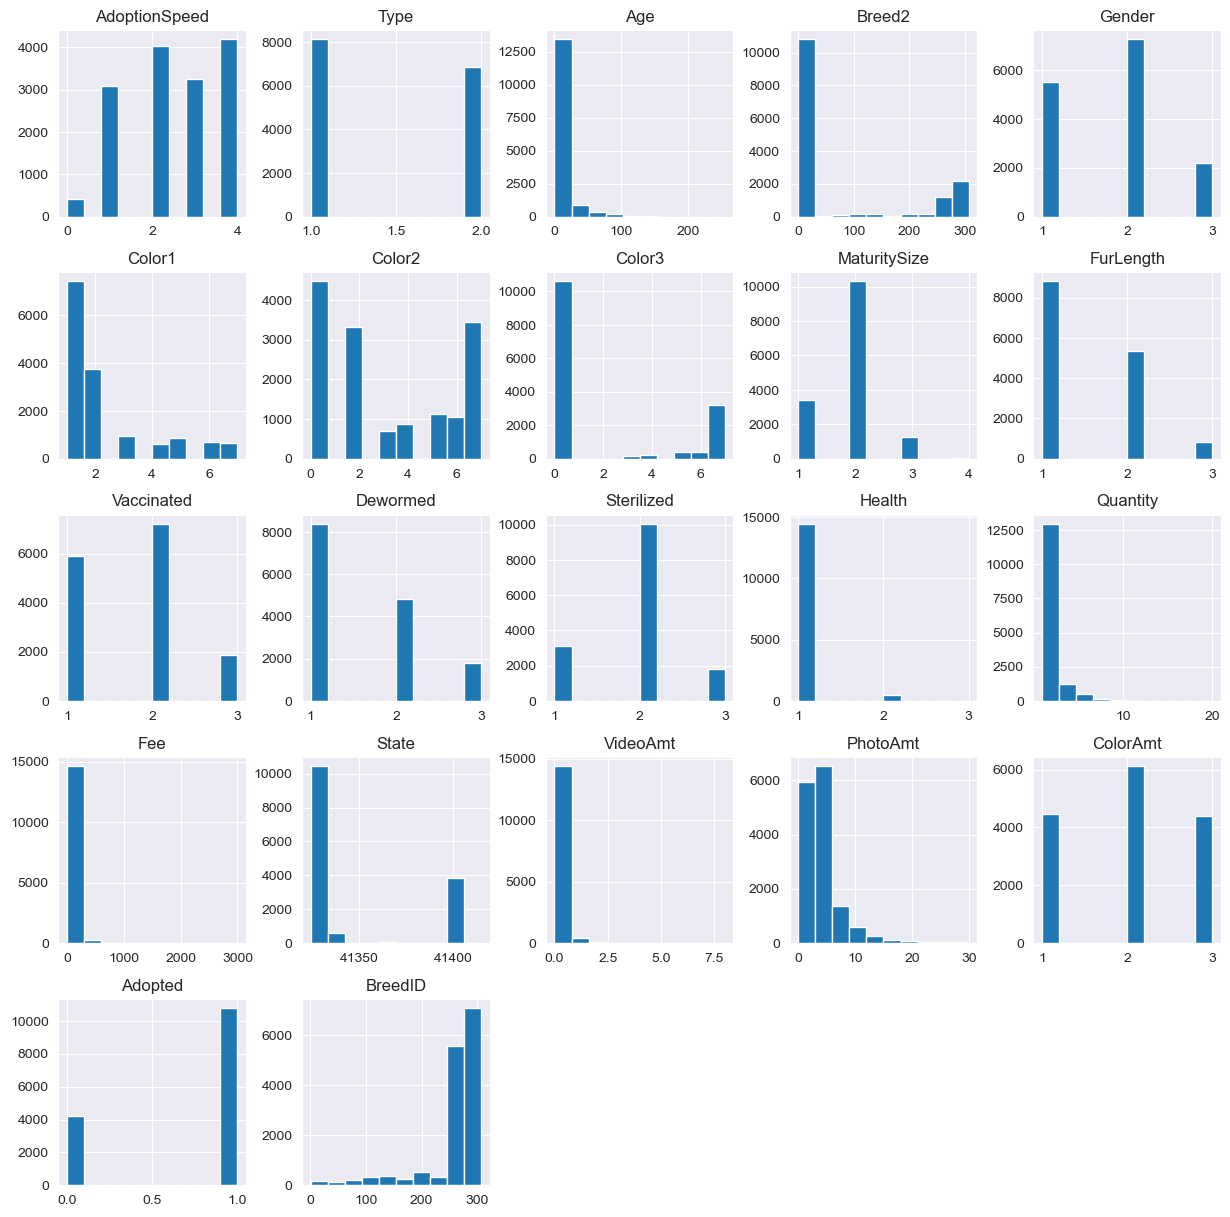

In [15]:
_ = pet_train.hist(figsize=(15, 15))

Based on the histogram of the "Type" feature, it appears that there are more dogs than cats in the dataset. However, when considering the distribution of "Breed1", there is a notable cluster on the far right side, suggesting a higher prevalence of cats.

Hypothesis: Despite the initial observation, it is plausible that there is a significant number of dogs categorized as mixed breeds (Breed1 = 307), which could skew the perception of the distribution. Further investigation into the difference between pet identified through Breed and pet identified through Type may provide insights into this discrepancy.

With Reference to Breed_labels Data File: Dog: 1-240, 307 | Cat: 241-306

< Problem : 12 data with data inconsitency >

In [16]:
# Filter the data for Breed1 in the range 1 to 240, 307 (dogs)
dog_breed_count1 = pet_train[(pet_train['Breed1'] >= 1) & (pet_train['Breed1'] <= 240)].shape[0]
dog_breed_count2 = pet_train[(pet_train['Breed1'] == 307)].shape[0]
dog_breed_count = dog_breed_count1+dog_breed_count2

# Filter the data for Type 1 (dogs)
dog_type_count = pet_train[(pet_train['Type'] == 1)].shape[0]

# Display the number of cats in the specified Breed1 range
print("Number of Dogs (Breed):", dog_breed_count)
print("Number of Dogs (Type):",dog_type_count)
print("Difference:",abs(dog_breed_count-dog_type_count))

Number of Dogs (Breed): 8144
Number of Dogs (Type): 8132
Difference: 12


In [17]:
# Filter the data for Breed1 in the range 241 to 306 (cats)
cat_breed_count = pet_train[(pet_train['Breed1'] >= 241) & (pet_train['Breed1'] <= 306)].shape[0]

# Filter the data for Type 2 (cats)
cat_type_count = pet_train[(pet_train['Type'] == 2)].shape[0]

# Display the number of cats in the specified Breed1 range
print("Number of Cats (Breed):", cat_breed_count)
print("Number of Cats (Type):",cat_type_count)
print("Difference:",abs(cat_breed_count-cat_type_count))

Number of Cats (Breed): 6849
Number of Cats (Type): 6861
Difference: 12


This indicates that there are 12 data with data inconsitency

< Cat identified as Mixed Breed > 4/12 data inconsistency

In [18]:
# Check for Cat identified as Mixed Breed, Wrong Breed
cat_MB = pet_train[(pet_train['Breed1']==307) & (pet_train['Type'] == 2)]
cat_MB_ID = cat_MB['PetID']
print("Cat-Mixed Breed: {}".format(len(cat_MB)))

Cat-Mixed Breed: 4


In [19]:
# Replace "Small" with "Short" in FurLengthName column
pet_train['FurLengthName'] = pet_train['FurLengthName'].replace('Small', 'Short')

# Verify the changes
print(pet_train['FurLengthName'].unique())

['Short' 'Medium' 'Long']


< Remedy >

In [20]:
# Change BreedName & Breed1 of Cat-Mixed Breed
################# BreedName ##########################
pet_train.loc[(pet_train['Breed1'] == 307) & (pet_train['Type'] == 2), 'BreedName'] = pet_train.loc[(pet_train['Breed1'] == 307) & (pet_train['Type'] == 2), 'FurLengthName'].apply(lambda x: f"Domestic {x} Hair")

################# Breed1 #############################
def FillBreed1():
    # Mapping of BreedName to Breed1
    breed_mapping = {
        "Domestic Long Hair": 264,
        "Domestic Medium Hair": 265,
        "Domestic Short Hair": 266
    }

    # Fill missing Breed1 values based on BreedName
    for breed_name, breed1 in breed_mapping.items():
        pet_train.loc[pet_train['BreedName'] == breed_name, 'Breed1'] = int(breed1)
        
FillBreed1()
########################################################

In [21]:
#################### Check #########################
filled_cat_MD = pet_train[pet_train['PetID'].isin(cat_MB_ID)]
print(filled_cat_MD[['PetID', 'BreedName','Breed1','Type']])
print("Cat-Mixed Breed: {}".format(len(pet_train[(pet_train['Breed1']==307) & (pet_train['Type'] == 2)])))

           PetID             BreedName Breed1  Type
10911  504134fd6  Domestic Medium Hair    265     2
13686  44f198a24   Domestic Short Hair    266     2
14058  7ec261d88   Domestic Short Hair    266     2
14470  40dfeeb65   Domestic Short Hair    266     2
Cat-Mixed Breed: 0


< Mismatch of Type & Breed > 8/12 data inconsistency

In [22]:
#Look at whether there's a mismatch of Type & Breed
print("Cat Type | Dog Breed: {}".format(len(pet_train[(pet_train['Breed1']>=1) & (pet_train['Breed1']<=240) & (pet_train['Type'] == 2)])))
print("Dog Type | Cat Breed: {}".format(len(pet_train[(pet_train['Breed1']>=241) & (pet_train['Breed1']<=306) & (pet_train['Type'] == 1)])))

Cat Type | Dog Breed: 8
Dog Type | Cat Breed: 0


In [23]:
#Cat Type | Dog Breed
filtered_data = (pet_train[(pet_train['Breed1']>=1) & (pet_train['Breed1']<=240) & (pet_train['Type'] == 2)])
print(filtered_data[['PetID', 'BreedName','Breed1','Breed2','Type']])
filtered_id = filtered_data.PetID

          PetID                   BreedName Breed1  Breed2  Type
22    1bc0f89d8                   Greyhound    114       0     2
1603  15a206d0d  Belgian Shepherd Laekenois     25       0     2
1638  f8654865f              Bearded Collie     21      21     2
3783  36b20cfb5  Belgian Shepherd Laekenois     25       0     2
4233  699a81c51                     Terrier    218     218     2
6650  85ec1aac0           Australian Kelpie     15       0     2
7300  6a72cfda7                      Collie     70       5     2
8852  6c399cb06                    Shih Tzu    205       0     2


In [24]:
# Determine whether is breed or type incorrect
# Iterate over the filtered data
for index, row in filtered_data.iterrows():
    description = row['Description']
    if 'cat' in description.lower() or 'kit' in description.lower():
        print(f"Row at index {index}: Description contains 'cat' or 'kitten'")
    elif 'dog' in description.lower() or 'pup' in description.lower():
        print(f"Row at index {index}: Description contains 'dog' or 'pup'")
    else:
        print(f"Row at index {index}: Description does not contain 'cat' or 'dog'")
#Results confirm that is the breed that is incorrect, not the type

Row at index 22: Description contains 'cat' or 'kitten'
Row at index 1603: Description does not contain 'cat' or 'dog'
Row at index 1638: Description contains 'cat' or 'kitten'
Row at index 3783: Description contains 'cat' or 'kitten'
Row at index 4233: Description contains 'cat' or 'kitten'
Row at index 6650: Description does not contain 'cat' or 'dog'
Row at index 7300: Description does not contain 'cat' or 'dog'
Row at index 8852: Description contains 'cat' or 'kitten'


Upon manual examination of the images located in the train_images folder corresponding to indices 1603, 6650, and 7300, it's evident that all of them depict cats. Therefore, the breed classification assigned to these entries appears to be inaccurate.

< Remedy >

In [25]:
########################## Set inaccurate values to NaN ##########################
pet_train.loc[(pet_train['Breed1'] >= 1) & (pet_train['Breed1'] <= 240) & (pet_train['Type'] == 2), 'BreedName'] = None
pet_train.loc[(pet_train['Breed1'] >= 1) & (pet_train['Breed1'] <= 240) & (pet_train['Type'] == 2), 'Breed2'] = int(0)
pet_train.loc[(pet_train['Breed1'] >= 1) & (pet_train['Breed1'] <= 240) & (pet_train['Type'] == 2), 'Breed1'] = int(0)

In [26]:
############### Check ##################################
filled_values = pet_train[pet_train['PetID'].isin(filtered_id)]
print(filled_values[['PetID', 'BreedName','Breed1','Breed2','Type']])

          PetID BreedName Breed1  Breed2  Type
22    1bc0f89d8      None      0       0     2
1603  15a206d0d      None      0       0     2
1638  f8654865f      None      0       0     2
3783  36b20cfb5      None      0       0     2
4233  699a81c51      None      0       0     2
6650  85ec1aac0      None      0       0     2
7300  6a72cfda7      None      0       0     2
8852  6c399cb06      None      0       0     2


In [27]:
# Change BreedName & Breed1 of the incorrect Breed values
################# BreedName ##########################
# Change BreedName of Cat-Mixed Breed
pet_train.loc[pet_train['PetID'].isin(filtered_id), 'BreedName'] = pet_train.loc[pet_train['PetID'].isin(filtered_id), 'FurLengthName'].apply(lambda x: f"Domestic {x} Hair")

################# Breed1 #############################
FillBreed1()
########################################################

In [28]:
#################### Check #########################
filled_cat_MD = pet_train[pet_train['PetID'].isin(filtered_id)]
print(filled_cat_MD[['PetID', 'BreedName','Breed1','Type']])
print("Cat-Mixed Breed: {}".format(len(pet_train[(pet_train['Breed1']==307) & (pet_train['Type'] == 2)])))

          PetID             BreedName Breed1  Type
22    1bc0f89d8  Domestic Medium Hair    265     2
1603  15a206d0d   Domestic Short Hair    266     2
1638  f8654865f   Domestic Short Hair    266     2
3783  36b20cfb5   Domestic Short Hair    266     2
4233  699a81c51    Domestic Long Hair    264     2
6650  85ec1aac0   Domestic Short Hair    266     2
7300  6a72cfda7   Domestic Short Hair    266     2
8852  6c399cb06    Domestic Long Hair    264     2
Cat-Mixed Breed: 0


### Feature 0 (Quantity)

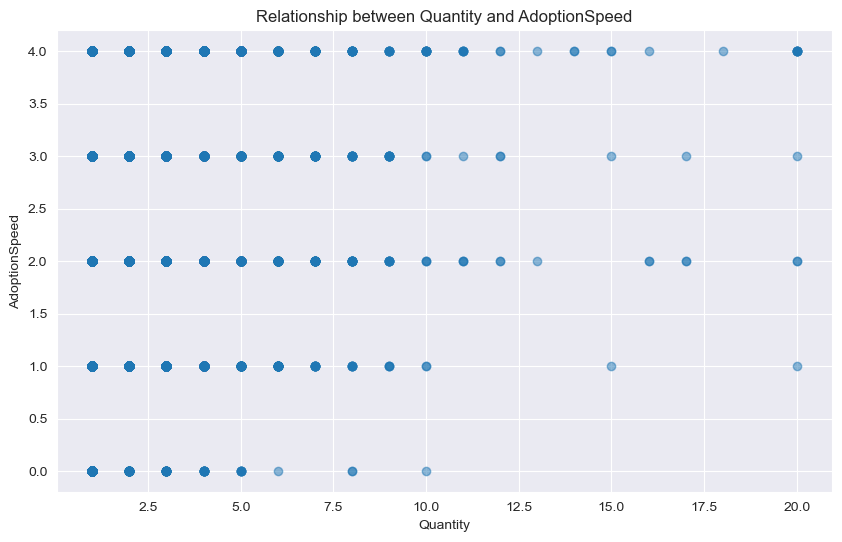

In [29]:
import matplotlib.pyplot as plt

# Scatter plot Quantity vs AdoptionSpeed
plt.figure(figsize=(10, 6))
plt.scatter(pet_train['Quantity'], pet_train['AdoptionSpeed'], alpha=0.5)
plt.title('Relationship between Quantity and AdoptionSpeed')
plt.xlabel('Quantity')
plt.ylabel('AdoptionSpeed')
plt.grid(True)
plt.show()

The scatter plot suggests a negative correlation between the quantity of pets in the profile and the adoption speed. As the number of pets increases, there appears to be a tendency for the adoption speed to decrease.

The may due to the presence of multiple pets in profiles may introduce uncertainty about each individual pet's characteristics, needs, and behavior, leading to a more cautious approach from potential adopters, as well as requiring more thorough consideration and evaluation, thus contributing to slower adoption speeds.

### Feature 1 (Name)

In [30]:
pet_train['Name'].head(10)

0                     Nibble
1                No Name Yet
2                     Brisco
3                       Miko
4                     Hunter
5                    No Name
6                      BULAT
7    Siu Pak & Her 6 Puppies
8                    No Name
9                      Kitty
Name: Name, dtype: object

In [31]:
pet_train['NameorNO'].value_counts()

NameorNO
Y    13627
N     1366
Name: count, dtype: int64

In [32]:
# Filter the DataFrame to names containing 'no name'
names_with_no_name = pet_train[pet_train['Name'].str.contains('no name', case=False)]

# Update the 'Name' column for the filtered rows to "No Name"
pet_train.loc[names_with_no_name.index, 'Name'] = "No Name"

# Count the occurrences 
no_name_counts = pet_train[pet_train['Name'].str.contains('no name', case=False)]['Name'].value_counts()

no_name_counts

Name
No Name    1370
Name: count, dtype: int64

In [33]:
# Find rows where 'Name' equals "No Name"
no_name_rows = pet_train['Name'] == "No Name"

# Update 'NameorNO' to 'N' for rows where 'Name' equals "No Name"
pet_train.loc[no_name_rows, 'NameorNO'] = 'N'

pet_train['NameorNO'].value_counts()

NameorNO
Y    13603
N     1390
Name: count, dtype: int64

In [34]:
# Find rows where 'NameorNO' equals "N"
no_name_rows = pet_train['NameorNO'] == "N"

# Update 'Name' to 'No Name' for rows where 'NameorNO' equals "N"
pet_train.loc[no_name_rows, 'Name'] = 'No Name'

pet_train['Name'].value_counts()

Name
No Name                   1390
Baby                        66
Lucky                       64
Brownie                     54
Mimi                        52
                          ... 
4 PUPPIES FOR ADOPTION       1
Trish                        1
Lab Mix Puppy 2              1
Pekengese Without Mka        1
Fili                         1
Name: count, Length: 9022, dtype: int64

In [35]:
# Filter the DataFrame to names containing 'no name'
names_with_no_name = pet_train[pet_train['Name'].str.contains('no name', case=False)]

# Count the occurrences 
no_name_counts = names_with_no_name['Name'].value_counts()

no_name_counts

Name
No Name    1390
Name: count, dtype: int64

In [36]:
pet_train['NameorNO'].value_counts()

NameorNO
Y    13603
N     1390
Name: count, dtype: int64

To address the issue of imbalanced data, where one group may dominate the analysis and skew the results, I've transformed it into a balanced dataset to ensure fair representation across all groups.

In [37]:
# Separate data into 'No Name' and 'Has Name' categories
no_name_data = pet_train[pet_train['Name'] == 'No Name']
has_name_data = pet_train[pet_train['Name'] != 'No Name']

# Sample the same number of instances from each category
sample_size = min(len(no_name_data), len(has_name_data))
balanced_data = pd.concat([no_name_data.sample(sample_size, random_state=42),
                           has_name_data.sample(sample_size, random_state=42)])

# Display the distribution of names in the balanced dataset
print(balanced_data['NameorNO'].value_counts())

NameorNO
N    1390
Y    1390
Name: count, dtype: int64


<Figure size 1000x600 with 0 Axes>

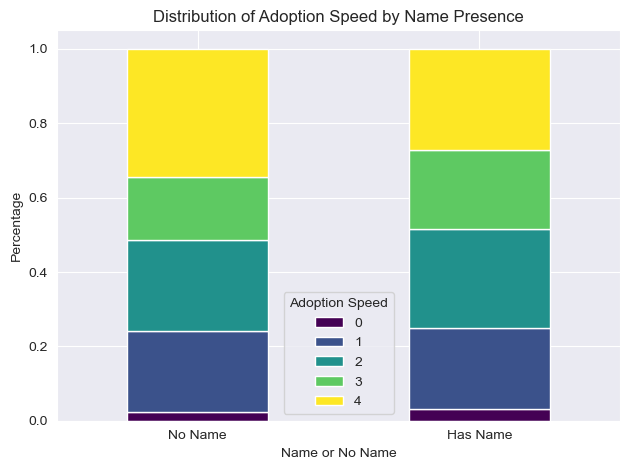

In [38]:
# Convert 'NameorNO' column to numeric
balanced_data['NameorNO_numeric'] = balanced_data['NameorNO'].apply(lambda x: 1 if x == 'Y' else 0)

# Calculate the total number of pets with and without names
total_with_name = balanced_data['NameorNO_numeric'].sum()
total_no_name = len(balanced_data) - total_with_name

# Group the data by the 'NameorNO' column and AdoptionSpeed, and calculate the count of each combination
adoption_speed_by_name = balanced_data.groupby(['NameorNO_numeric', 'AdoptionSpeed']).size().unstack()

# Normalize the counts by the total number of pets in each category
adoption_speed_by_name_normalized = adoption_speed_by_name.div([total_no_name, total_with_name], axis=0)

# Plot the bar plot
plt.figure(figsize=(10, 6))
adoption_speed_by_name_normalized.plot(kind='bar', stacked=True, cmap='viridis')

# Add labels and title
plt.title('Distribution of Adoption Speed by Name Presence')
plt.xlabel('Name or No Name')
plt.ylabel('Percentage')
plt.xticks(ticks=[0, 1], labels=['No Name', 'Has Name'], rotation=0)

# Show plot
plt.legend(title='Adoption Speed')
plt.tight_layout()
plt.show()


Based on the stacked bar diagram, it's evident that pets with names have a higher likelihood of being adopted faster

### Feature 2 (Age in months)

In [39]:
cat = pet_train[pet_train['Type'] == 2]
dog = pet_train[pet_train['Type'] == 1]

In [40]:
small_dog = dog[dog['MaturitySize']==1]
medium_dog = dog[dog['MaturitySize']==2]
large_dog = dog[dog['MaturitySize']==3]
giant_dog = dog[dog['MaturitySize']==4]

In [41]:
print("small_dog")
print(small_dog.Age.describe())
print("")
print("medium_dog")
print(medium_dog.Age.describe())
print("")
print("large_dog")
print(large_dog.Age.describe())
print("")
print("giant_dog")
print(giant_dog.Age.describe())


small_dog
count    1223.000000
mean       21.360589
std        27.173143
min         0.000000
25%         2.000000
50%         9.000000
75%        36.000000
max       135.000000
Name: Age, dtype: float64

medium_dog
count    6127.000000
mean        9.949404
std        18.209308
min         0.000000
25%         2.000000
50%         3.000000
75%         9.000000
max       255.000000
Name: Age, dtype: float64

large_dog
count    760.000000
mean      22.625000
std       26.787313
min        0.000000
25%        3.000000
50%       12.000000
75%       36.000000
max      144.000000
Name: Age, dtype: float64

giant_dog
count     22.000000
mean      30.636364
std       29.287646
min        2.000000
25%       12.000000
50%       24.000000
75%       36.000000
max      120.000000
Name: Age, dtype: float64


Based on data from PetMD, the average lifespan of dogs varies across different size categories: 
small dogs typically live between 120 to 180 months, 
medium-sized dogs between 120 to 156 months, 
large dogs between 120 to 144 months, 
and giant dogs between 96 to 120 months.

Upon analysis, it is evident that there are outliers observed in the medium-sized dog category.

In [42]:
num_outliners_dog = medium_dog[medium_dog['Age'] > 156].shape[0]

In [43]:
cat.Age.describe()

count    6861.000000
mean        7.543361
std        12.771554
min         0.000000
25%         2.000000
50%         3.000000
75%         8.000000
max       212.000000
Name: Age, dtype: float64

Based on information from PetMD, the average lifespan of cats falls within the range of 156 to 204 months. However, there are outliers detected within the cat population.

In [44]:
num_outliners_cat = cat[cat['Age']>204].shape[0]

In [45]:
print("Total outlier for cat: ", num_outliners_cat)

print("Total outlier for dog: ", num_outliners_dog)

Total outlier for cat:  2
Total outlier for dog:  6


In [46]:
before = pet_train.shape[0]

pet_train.drop(pet_train[(pet_train["Type"]==2) & (pet_train["Age"]>204)].index, inplace = True) 

pet_train.drop(pet_train[(pet_train["Type"]==1) & (pet_train["Age"]>156)].index, inplace = True)

after = pet_train.shape[0]

difference = before - after
difference

8

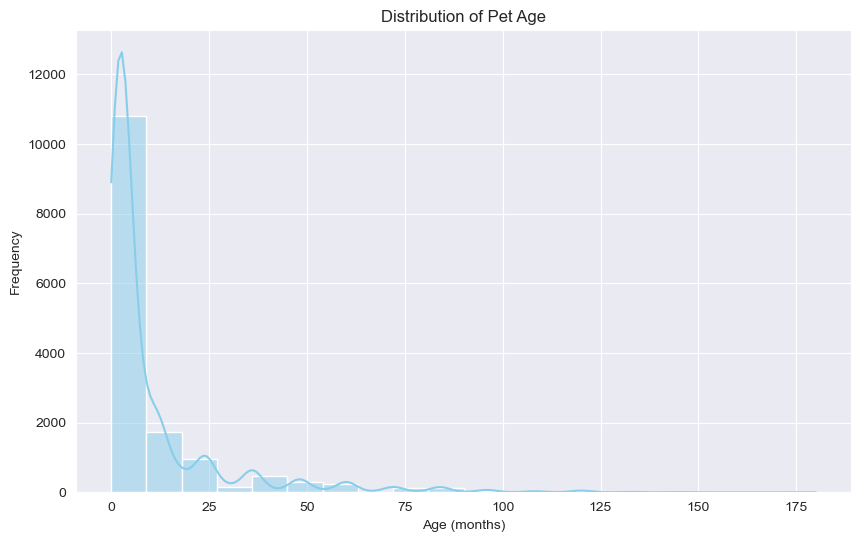

In [47]:
# Plot the distribution of Age
plt.figure(figsize=(10, 6))
sns.histplot(pet_train['Age'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Pet Age')
plt.xlabel('Age (months)')
plt.ylabel('Frequency')
plt.show()

From the age distribution plot, it's evident that the majority of pets fall within the age range of 0 to 8 Months.

<Figure size 1200x800 with 0 Axes>

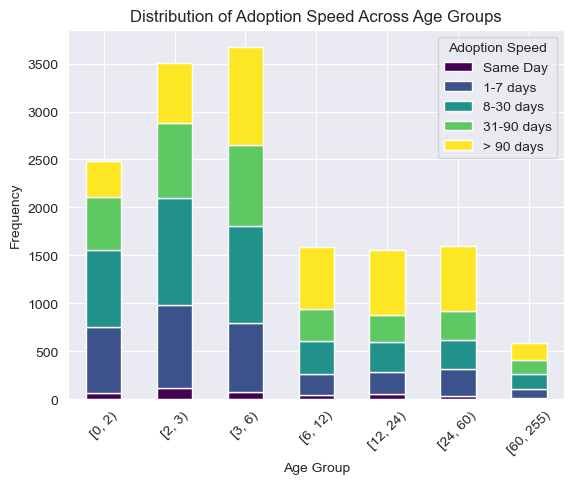

In [48]:
# Define the age bins
age_bins = [0, 2, 3, 6, 12, 24, 60, 255]

# Create a new column 'AgeGroup' based on the age bins
pet_train['AgeGroup'] = pd.cut(pet_train['Age'], bins=age_bins, right=False)

# Create a pivot table to count the frequency of each AdoptionSpeed for each AgeGroup
pivot_table = pet_train.pivot_table(index='AgeGroup', columns='AdoptionSpeed', aggfunc='size', fill_value=0)

# Plot the stacked bar plot
plt.figure(figsize=(12, 8))
pivot_table.plot(kind='bar', stacked=True, cmap='viridis')
plt.title('Distribution of Adoption Speed Across Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(title='Adoption Speed', labels=['Same Day', '1-7 days', '8-30 days', '31-90 days', '> 90 days'])
plt.show()


Based on the stacked bar plot, it's evident that younger pets tend to be adopted more quickly. This suggests a correlation between age and adoption speed, with younger pets being preferred by adopters

In [49]:
# Define the bins and labels
bins = [0, 2, 3, 6, 12, 24, 60, 255]

labels = [0, 1, 2, 3, 4, 5, 6]

# Bin the 'AgeBins' column and create a new column 'AgeCategory' with mapped values
pet_train['AgeCategory'] = pd.cut(pet_train['Age'], bins=bins, labels=labels, right=False)

# Display the DataFrame with the new column
print(pet_train[['Age', 'AgeCategory']])


       Age AgeCategory
0        3           2
1        1           0
2        1           0
3        4           2
4        1           0
...    ...         ...
14988    2           1
14989   60           6
14990    2           1
14991    9           3
14992    1           0

[14985 rows x 2 columns]


In [50]:
pet_train['AgeCategory'].value_counts()

AgeCategory
2    3670
1    3503
0    2483
5    1601
3    1588
4    1557
6     583
Name: count, dtype: int64

### Feature 3 (Type: Dog V Cat)

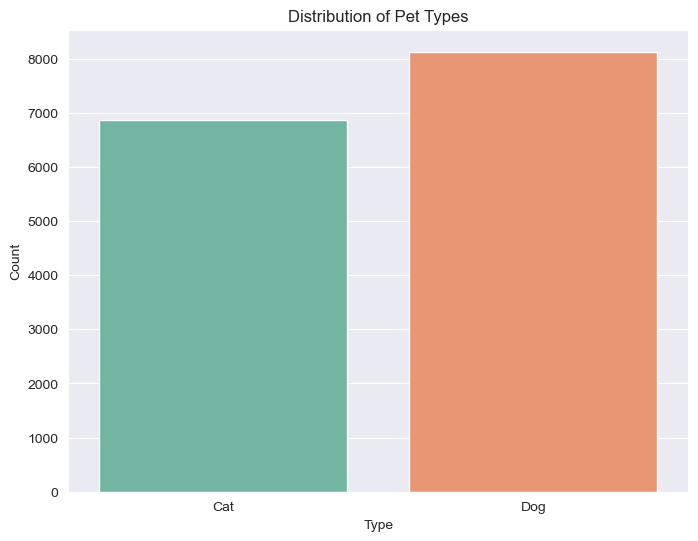

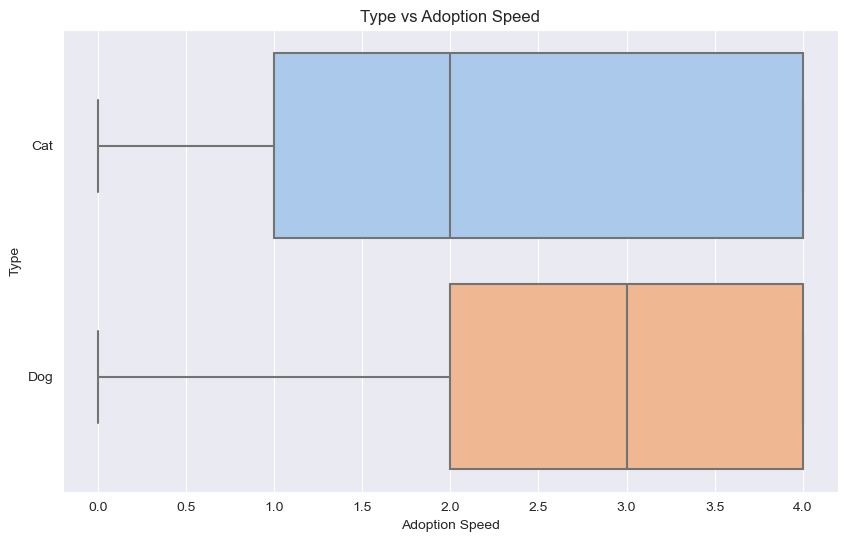

In [51]:
# Map type values to labels
type_labels = {1: 'Dog', 2: 'Cat'}
pet_train['Type_label'] = pet_train['Type'].map(type_labels)

# Plot the distribution of Type
plt.figure(figsize=(8, 6))
sns.countplot(data=pet_train, x='Type_label', palette='Set2')
plt.title('Distribution of Pet Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

# Plot the relationship between Type and AdoptionSpeed
plt.figure(figsize=(10, 6))
sns.boxplot(data=pet_train, x='AdoptionSpeed', y='Type_label', palette='pastel')
plt.title('Type vs Adoption Speed')
plt.xlabel('Adoption Speed')
plt.ylabel('Type')
plt.show()



The diagram illustrates that there are more dogs than cats. However, the box plot indicates that cats are more likely to be adopted faster.

In [52]:
# Contingency table of adoption speed and type of animal
contingency_table = pd.crosstab(pet_train['Type'], pet_train['AdoptionSpeed'])

# Chi-square test of independence
chi2_stat, p_val, _, _ = stats.chi2_contingency(contingency_table)

# Determine which type of animal is adopted sooner based on median adoption speed
median_adoption_speed = pet_train.groupby('Type')['AdoptionSpeed'].median()

# Print median adoption speed for each type
print("Median Adoption Speed by Type:")
print(median_adoption_speed)

# Print results of chi-square test
print("\nChi-Square Test of Independence:")
print("Chi-Square Statistic:", chi2_stat)
print("P-value:", p_val)

# Interpretation of results
alpha = 0.05
if p_val < alpha:
    print("\nThere is a significant difference in adoption speed between cats and dogs (p < 0.05).")
    faster_type = median_adoption_speed.idxmin()
    if faster_type == 1:
        faster_type = "dog"
    else:
        faster_type = "cat"
    print(f"The {faster_type} is likely to be adopted sooner.")
else:
    print("\nThere is no significant difference in adoption speed between cats and dogs (p >= 0.05).")


Median Adoption Speed by Type:
Type
1    3.0
2    2.0
Name: AdoptionSpeed, dtype: float64

Chi-Square Test of Independence:
Chi-Square Statistic: 161.90229756851048
P-value: 5.713705147705946e-34

There is a significant difference in adoption speed between cats and dogs (p < 0.05).
The cat is likely to be adopted sooner.


### Feature 4 (Gender)

In [53]:
pet_train['Gender'].value_counts()

Gender
2    7275
1    5531
3    2179
Name: count, dtype: int64

In [54]:
# Stratified sampling to create a balanced dataset
train_data, _ = train_test_split(pet_train, test_size=0.3, stratify=pet_train['Gender'], random_state=42)

# Display the distribution of gender in the balanced dataset
print(train_data['Gender'].value_counts())


Gender
2    5092
1    3872
3    1525
Name: count, dtype: int64


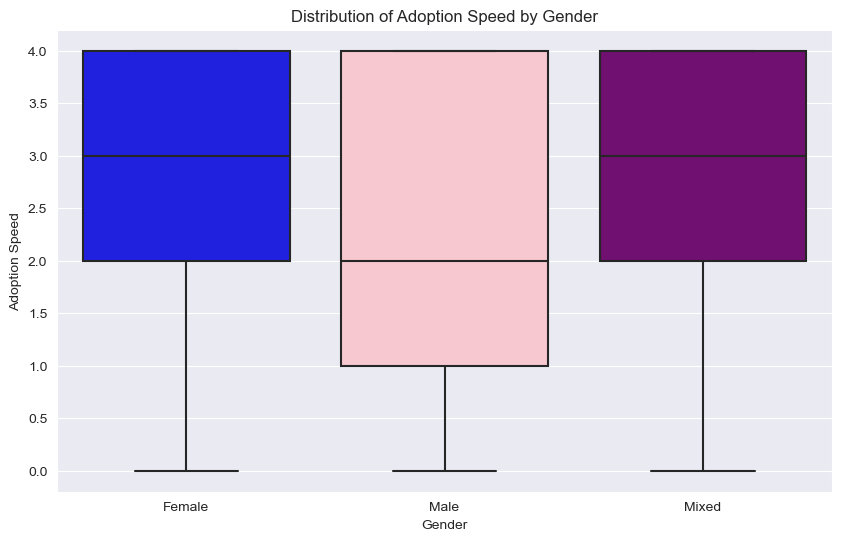

In [55]:
# Define a color palette
palette = ['blue', 'pink', 'purple']

# Map numerical gender codes to gender names
gender_mapping = {1: 'Male', 2: 'Female', 3: 'Mixed'}
train_data['Gender_name'] = train_data['Gender'].map(gender_mapping)

# Create box plot with gender names
plt.figure(figsize=(10, 6))
sns.boxplot(x='Gender_name', y='AdoptionSpeed', data=train_data,palette=palette)
plt.xlabel('Gender')
plt.ylabel('Adoption Speed')
plt.title('Distribution of Adoption Speed by Gender')
plt.show()


Based on the box plot, it appears that male pets have a lower median adoption speed compared to females and mixed breeds. Specifically, the median adoption speed for male pets is 2, while for females and mixed breeds, it is 3. This suggests that, on average, male pets are adopted faster than females and mixed breeds.

In [56]:
# Filter the dataset by gender
male_pets = pet_train[pet_train['Gender'] == 1]['AdoptionSpeed']
female_pets = pet_train[pet_train['Gender'] == 2]['AdoptionSpeed']
mixed_pets = pet_train[pet_train['Gender'] == 3]['AdoptionSpeed']

# Identify the gender with the lowest median adoption speed
median_adoption_speeds = {
    'Male': male_pets.median(),
    'Female': female_pets.median(),
    'Mixed': mixed_pets.median()
}

fastest_gender = min(median_adoption_speeds, key=median_adoption_speeds.get)
print("Gender most likely to be adopted sooner:", fastest_gender)


Gender most likely to be adopted sooner: Male


### Feature 5 (PhotoAmt)

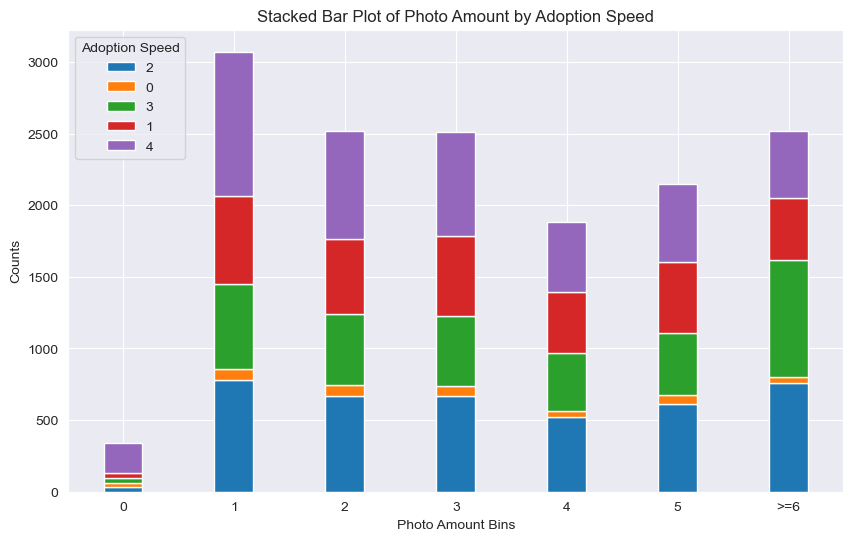

In [57]:
# Data preparation
adoption_speeds = pet_train['AdoptionSpeed'].unique()
photo_amt_bins = sorted(pet_train['PhotoAmtBins'].unique())
photo_amt_counts = []

for speed in adoption_speeds:
    counts = pet_train[pet_train['AdoptionSpeed'] == speed]['PhotoAmtBins'].value_counts().sort_index()
    photo_amt_counts.append(counts)

# Plotting
labels = [str(i) for i in adoption_speeds]
width = 0.35
x = range(len(photo_amt_bins))

fig, ax = plt.subplots(figsize=(10, 6))
bottom = [0] * len(x)

for i, counts in enumerate(photo_amt_counts):
    ax.bar(x, counts.reindex(photo_amt_bins, fill_value=0), width, label=labels[i], bottom=bottom)
    bottom = [bottom[j] + counts.get(j, 0) for j in x]

ax.set_ylabel('Counts')
ax.set_xlabel('Photo Amount Bins')
ax.set_title('Stacked Bar Plot of Photo Amount by Adoption Speed')
ax.legend(title='Adoption Speed')
plt.xticks(x, photo_amt_bins)
plt.show()


The plot clearly indicates that pets with zero photos are significantly less likely to be adopted. Moreover, as the number of photos increases, the likelihood of adoption decreases. Hence, the quantity of images is indeed a crucial factor influencing adoption outcomes.

In [58]:
# Define a function to map values to the range [0, 6]
def map_photo_amt(photo_amt):
    if photo_amt > 6:
        return 6
    else:
        return photo_amt

# Apply the function to create a new column 'PhotoAmt_Adjusted'
pet_train['PhotoAmt_Adjusted'] = pet_train['PhotoAmt'].apply(map_photo_amt)

# Display the DataFrame with the new column
print(pet_train[['PhotoAmt', 'PhotoAmt_Adjusted']])


       PhotoAmt  PhotoAmt_Adjusted
0             1                  1
1             2                  2
2             7                  6
3             8                  6
4             3                  3
...         ...                ...
14988         3                  3
14989         3                  3
14990         5                  5
14991         3                  3
14992         1                  1

[14985 rows x 2 columns]


In [59]:
pet_train['PhotoAmt_Adjusted'].value_counts()

PhotoAmt_Adjusted
1    3072
2    2518
6    2518
3    2509
5    2146
4    1881
0     341
Name: count, dtype: int64

### Feature 6 (Breed)

In [60]:
# Set Breed2 = 0 for those Breed1 = Breed2 
pet_train.loc[pet_train['Breed1'] == pet_train['Breed2'], 'Breed2'] = 0

In [61]:
# Check
pet_train[pet_train['Breed1'] == pet_train['Breed2']]

,PetID,AdoptionSpeed,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,...,StateName,StateBinsName,ColorName,AdoptedName,BreedID,BreedName_BreedLabels,AgeGroup,AgeCategory,Type_label,PhotoAmt_Adjusted


In [62]:
# Define a dictionary to map 'Y' to 1 and 'N' to 0
mapping = {'Y': 1, 'N': 0}

# Use the map function to apply the mapping to the 'BreedPure' column
pet_train['BreedPure'] = pet_train['BreedPure'].map(mapping)


In [63]:
# Update BreedPure based on Breed2
pet_train.loc[pet_train['Breed2'] == 0, 'BreedPure'] = 1


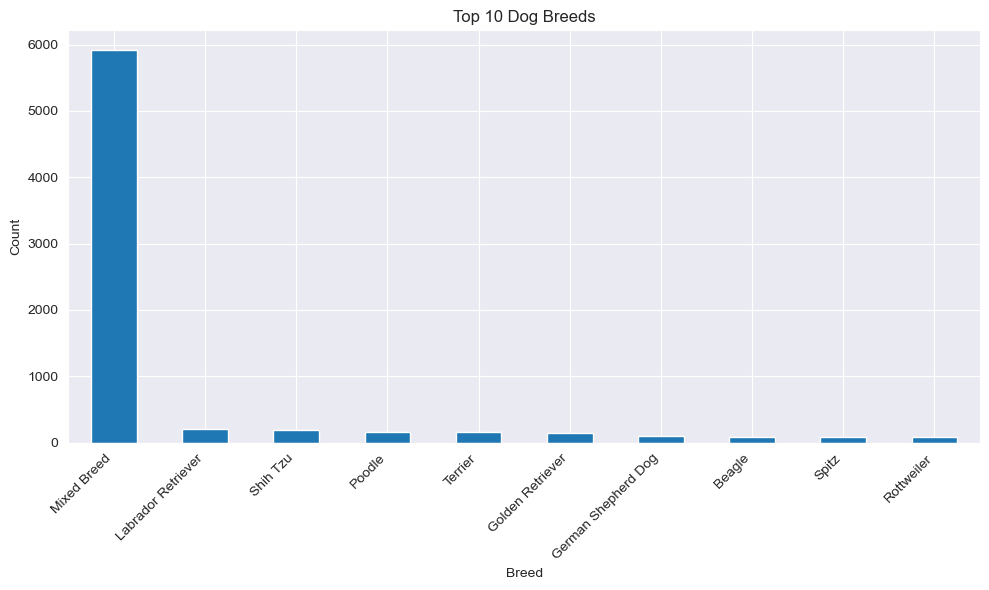

In [64]:
# Filter the pet_train dataframe for dogs
dog_data = pet_train[pet_train['Type'] == 1]

# Group by BreedName and count occurrences
breed_counts = dog_data['BreedName'].value_counts()

# Select top 10 breeds
top_10_breeds = breed_counts.head(10)

# Plot the graph
plt.figure(figsize=(10, 6))
top_10_breeds.plot(kind='bar')
plt.title('Top 10 Dog Breeds')
plt.xlabel('Breed')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better readability
plt.tight_layout()
plt.show()



From the diagram, it's evident that the majority of dogs in the dataset belong to the 'Mixed Breed' category.

In [65]:
# Filter the pet_train dataframe for dogs
dog_data = pet_train[pet_train['Type'] == 1]

# Group by BreedName and count occurrences
breed_counts = dog_data['BreedName'].value_counts()

# Select top 15 breeds
top_15_breeds = breed_counts.head(15)

# Filter dog data for the top 15 breeds
top_15_dog_data = dog_data[dog_data['BreedName'].isin(top_15_breeds.index)]

# Calculate median adoption speed for each breed in the top 15
median_adoption_speed_top_15 = top_15_dog_data.groupby('BreedName')['AdoptionSpeed'].median()

# Find the fastest dog breed in the top 15 based on median adoption speed
fastest_breed_top_15 = median_adoption_speed_top_15.idxmin()
fastest_speed_top_15 = median_adoption_speed_top_15.min()

# Get the number of data points for the fastest breed in the top 15
num_data_points_top_15 = breed_counts[fastest_breed_top_15]

print(f"The fastest dog breed to be adopted among the top 15 is '{fastest_breed_top_15}' with a median adoption speed of {fastest_speed_top_15}, based on {num_data_points_top_15} data points.")



The fastest dog breed to be adopted among the top 15 is 'Beagle' with a median adoption speed of 2.0, based on 90 data points.


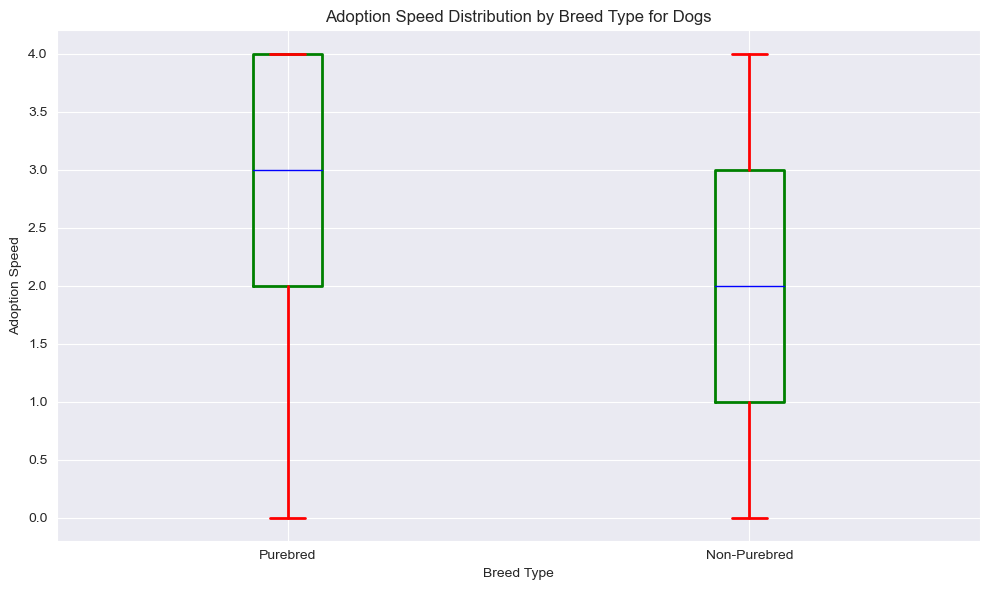

In [66]:
# Separate data for purebred and non-purebred dogs
purebred_data = pet_train[pet_train['BreedPure'] == 1]
non_purebred_data = pet_train[pet_train['BreedPure'] == 0]

# Create a box plot with customized styles
plt.figure(figsize=(10, 6))
plt.boxplot([purebred_data['AdoptionSpeed'], non_purebred_data['AdoptionSpeed']],
            labels=['Purebred', 'Non-Purebred'],
            medianprops={'color': 'blue'},  # Color of the median line
            boxprops={'color': 'green', 'linewidth': 2},  # Color and width of the box outline
            whiskerprops={'color': 'red', 'linewidth': 2},  # Color and width of the whiskers
            capprops={'color': 'red', 'linewidth': 2})  # Color and width of the caps (line at the ends of whiskers)
plt.title('Adoption Speed Distribution by Breed Type for Dogs')
plt.xlabel('Breed Type')
plt.ylabel('Adoption Speed')
plt.tight_layout()
plt.show()


The box plot reveals that the median adoption speed for both purebred and non-purebred dogs is similar. However, there is a notable difference in the distribution of adoption speeds between the two groups. For non-purebred dogs, the 75th percentile mark aligns with the median line but is lower compared to purebred dogs, indicating a faster adoption rate for non-purebred dogs in the upper quartile.

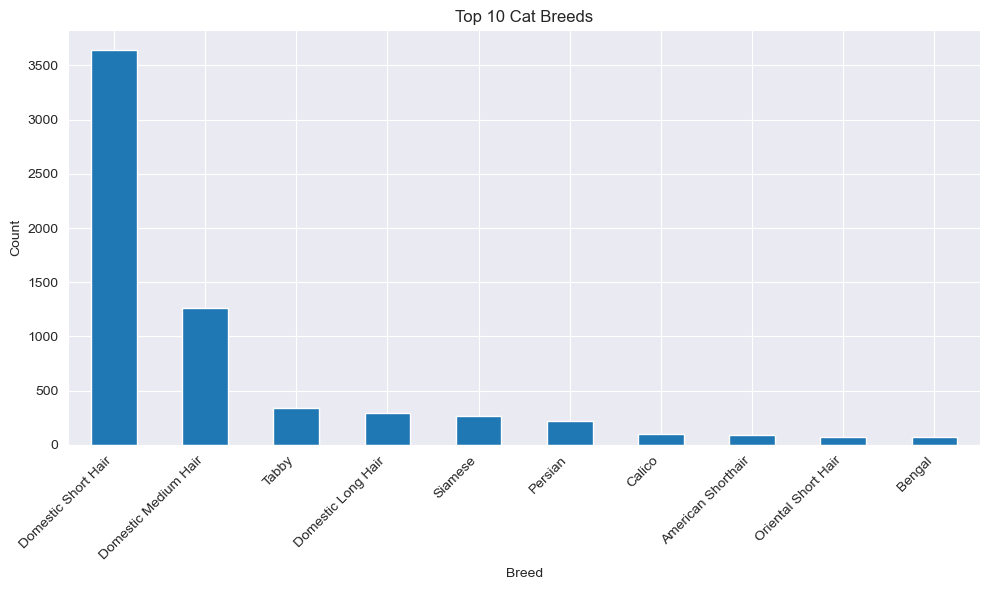

In [67]:
# Filter the pet_train dataframe for cats
cat_data = pet_train[pet_train['Type'] == 2]

# Group by BreedName and count occurrences
breed_counts = cat_data['BreedName'].value_counts()

# Select top 20 breeds
top_10_breeds = breed_counts.head(10)

# Plot the graph
plt.figure(figsize=(10, 6))
top_10_breeds.plot(kind='bar')
plt.title('Top 10 Cat Breeds')
plt.xlabel('Breed')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better readability
plt.tight_layout()
plt.show()


From the diagram, it's evident that the majority of cats in the dataset belong to the 'Domestic Short Hair' category.

In [68]:
# Filter the pet_train dataframe for cats
cat_data = pet_train[pet_train['Type'] == 2]

# Group by BreedName and count occurrences
breed_counts = cat_data['BreedName'].value_counts()

# Select top 15 breeds
top_15_breeds = breed_counts.head(15)

# Filter cat data for the top 15 breeds
top_15_cat_data = cat_data[cat_data['BreedName'].isin(top_15_breeds.index)]

# Calculate median adoption speed for each breed in the top 15
median_adoption_speed_top_15 = top_15_cat_data.groupby('BreedName')['AdoptionSpeed'].median()

# Find the fastest cat breed in the top 15 based on median adoption speed
fastest_breed_top_15= median_adoption_speed_top_15.idxmin()
fastest_speed_top_15= median_adoption_speed_top_15.min()

# Get the number of data points for the fastest breed in the top 15
num_data_points_top_15 = breed_counts[fastest_breed_top_15]

print(f"The fastest cat breed to be adopted among the top 15 is '{fastest_breed_top_15}' with a median adoption speed of {fastest_speed_top_15}, based on {num_data_points_top_15} data points.")


The fastest cat breed to be adopted among the top 15 is 'Bengal' with a median adoption speed of 2.0, based on 71 data points.


Conclusion:

Dog Adoption Insights:

The Beagle breed stands out as the fastest to be adopted among the top 15 dog breeds, boasting a median adoption speed of 2.0, drawn from a substantial dataset of 90 data points. Notably, the dataset is largely dominated by dogs categorized under 'Mixed Breed,' suggesting their prevalence in adoption centers or shelters.
Analyzing the distribution of adoption speeds using box plots reveals intriguing patterns between purebred and non-purebred dogs. While the median adoption speed remains comparable, there is a distinct difference in the upper quartile. For non-purebred dogs, the 75th percentile mark aligns lower than that of purebred dogs, indicating a potentially faster adoption rate for non-purebred dogs in this segment.
Cat Adoption Insights:

In the realm of cats, the Bengal breed emerges as the quickest to find adoption, with a median adoption speed of 2.0, based on a dataset encompassing 71 data points. Similarly, the dataset showcases a significant presence of cats classified under 'Domestic Short Hair,' indicating their prominence in adoption environments.

### Feature 7 (Maturity Size)

ANOVA F-statistic: 31.655465315543005
ANOVA p-value: 2.1740671490617817e-20


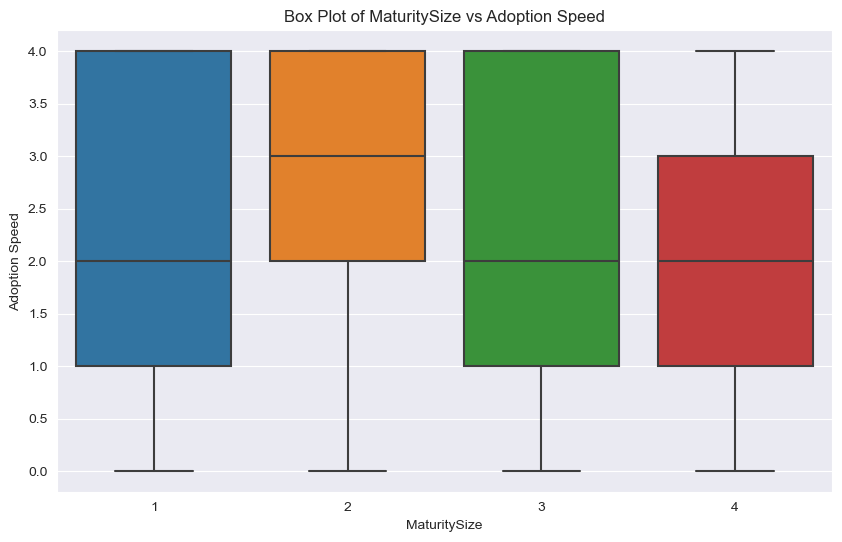

In [69]:
# Perform ANOVA test
anova_result = stats.f_oneway(*[pet_train[pet_train['MaturitySize'] == size]['AdoptionSpeed'] for size in pet_train['MaturitySize'].unique()])

# Print ANOVA results
print("ANOVA F-statistic:", anova_result.statistic)
print("ANOVA p-value:", anova_result.pvalue)

# Plot box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='MaturitySize', y='AdoptionSpeed', data=pet_train)
plt.title('Box Plot of MaturitySize vs Adoption Speed')
plt.xlabel('MaturitySize')
plt.ylabel('Adoption Speed')
plt.show()


The box plot analysis reveals that pets classified as having a 'Medium' MaturitySize tend to exhibit a higher median Adoption Speed, with a value of 3, compared to pets of other sizes.

Conclusion:
Additionally, it's important to note that there appears to be no clear relationship between Adoption Speed and MaturitySize as it increases. The observed slower median Adoption Speed for pets categorized with a 'Medium' MaturitySize could be influenced by other factors such as breed and pet type.

### Feature 8 (Furlength)

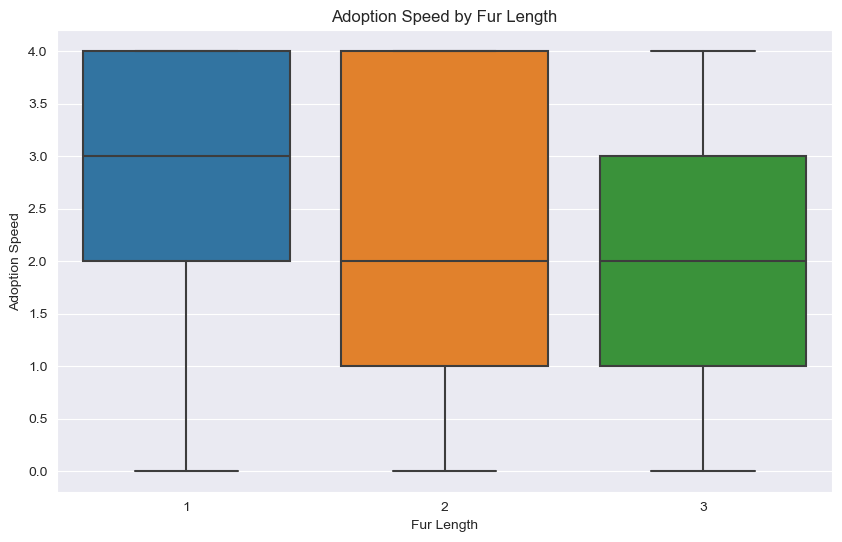

ANOVA p-value: 7.2606149864237785e-34
T-test between 1 and 2: p-value = 1.3153483071767956e-08
T-test between 1 and 3: p-value = 1.068637918228163e-32
T-test between 2 and 3: p-value = 2.4679573319116713e-18


In [70]:
# Box plot to visualize the distribution of adoption speeds for each fur length category
plt.figure(figsize=(10, 6))
sns.boxplot(x='FurLength', y='AdoptionSpeed', data=pet_train)
plt.title('Adoption Speed by Fur Length')
plt.xlabel('Fur Length')
plt.ylabel('Adoption Speed')
plt.show()


# One-way ANOVA test to compare adoption speeds across fur length categories
anova_result = f_oneway(*(pet_train[pet_train['FurLength'] == length]['AdoptionSpeed'] for length in pet_train['FurLength'].unique()))
print("ANOVA p-value:", anova_result.pvalue)

# T-test to compare adoption speeds between different fur length categories
fur_lengths = pet_train['FurLength'].unique()
for i in range(len(fur_lengths)):
    for j in range(i + 1, len(fur_lengths)):
        length1 = fur_lengths[i]
        length2 = fur_lengths[j]
        group1 = pet_train[pet_train['FurLength'] == length1]['AdoptionSpeed']
        group2 = pet_train[pet_train['FurLength'] == length2]['AdoptionSpeed']
        ttest_result = ttest_ind(group1, group2)
        print(f"T-test between {length1} and {length2}: p-value =", ttest_result.pvalue)

The box plot analysis indicates a trend where longer fur lengths correspond to faster adoption speeds. Specifically, pets with short fur lengths exhibit a median adoption speed of 3, while those with medium and long fur lengths show a median adoption speed of 2. Interestingly, pets with long fur lengths also display a lower value at the 75th quartile compared to those with medium fur lengths, suggesting that pets with longer fur may tend to be adopted more quickly.

### Feature 9 (Fee)

In [71]:
pet_train.Fee.describe()

count    14985.000000
mean        21.271338
std         78.433939
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       3000.000000
Name: Fee, dtype: float64

Around 85% of total adoption posting have zero Fee.
And there seems some outlier because max fee value is 3000 and that seems alot. We'll do some analysis on fee values.

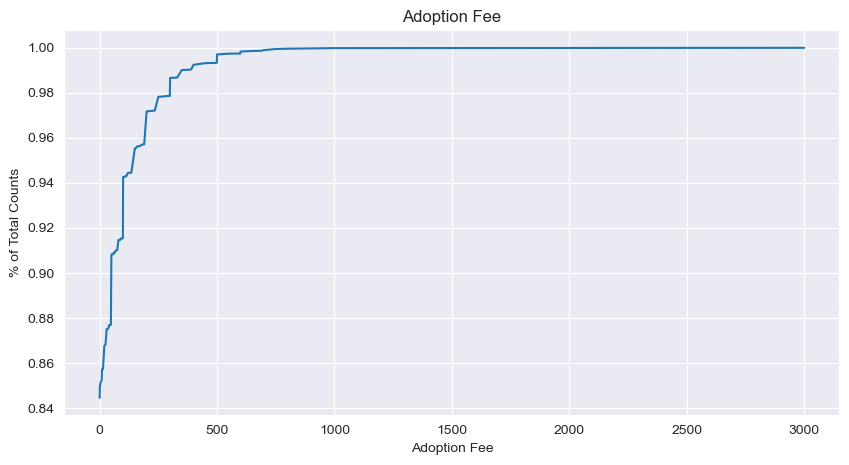

In [72]:
# Sort the fee counts by index
sorted_fee_counts = pet_train['Fee'].value_counts().sort_index()

# Calculate cumulative percentage of total counts
cumulative_percentage = np.cumsum(sorted_fee_counts.values) / np.sum(sorted_fee_counts.values)

# Plot the line plot
plt.figure(figsize=(10, 5))
plt.plot(sorted_fee_counts.index, cumulative_percentage)
plt.title("Adoption Fee")
plt.ylabel("% of Total Counts")
plt.xlabel("Adoption Fee")
plt.grid(True)
plt.show()

In [73]:
pet_train[pet_train["Fee"]>1000]

,PetID,AdoptionSpeed,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,...,StateName,StateBinsName,ColorName,AdoptedName,BreedID,BreedName_BreedLabels,AgeGroup,AgeCategory,Type_label,PhotoAmt_Adjusted
8722,e74dd0579,3,1,Khaleesi And Drogo,4,103,0,3,1,2,...,Kedah,Others,Black,Y,103,German Shepherd Dog,"[3, 6)",2,Dog,5
10477,31a77d7ba,1,1,Bull Dog,24,82,0,1,2,5,...,Kuala Lumpur,Kuala Lumpur,Brown,Y,82,English Bulldog,"[24, 60)",5,Dog,3


Based on the analysis, it is evident that the overwhelming majority (99.99%) of adoptions involve pets with fees below 1000 dollar .Consequently, entries with fees exceeding 1000 dollar were deemed outliers and should removed from the dataset. This action was taken due to the minimal number of such entries, with only two instances identified.

In [74]:
print("Before Fee outlier removal:", pet_train.shape[0])
pet_train.drop(pet_train[pet_train["Fee"]>1000].index, inplace = True) 
print("After Fee outlier removal:", pet_train.shape[0])

Before Fee outlier removal: 14985
After Fee outlier removal: 14983


In [75]:
# Create a new column 'Free' where 1 indicates free and 0 indicates not free
pet_train['Free'] = (pet_train['Fee'] == 0).astype(int)


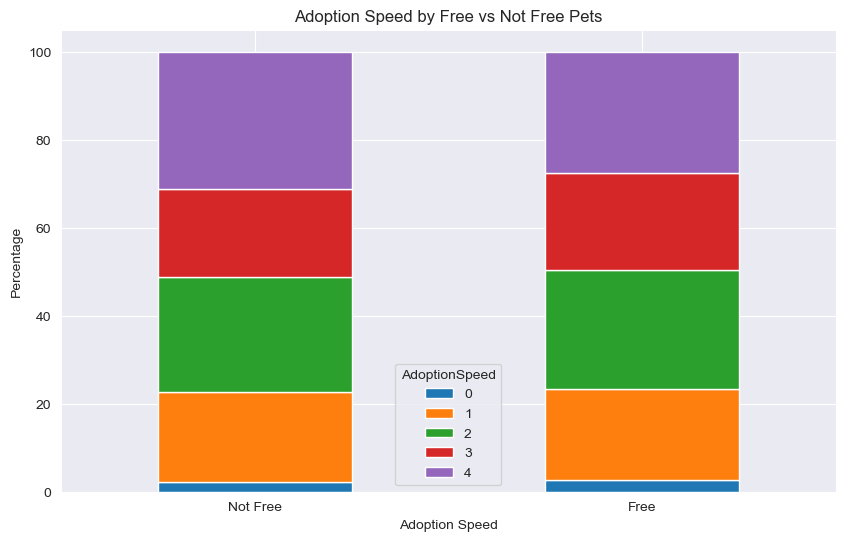

In [76]:
# Group data by 'Free' and 'AdoptionSpeed', and calculate the count of each group
free_adoption_speed_counts = pet_train.groupby(['Free', 'AdoptionSpeed']).size().unstack()

# Calculate the percentage of each group
total_by_free = free_adoption_speed_counts.sum(axis=1)
free_adoption_speed_perc = free_adoption_speed_counts.div(total_by_free, axis=0) * 100

# Plot the stacked bar plot
ax = free_adoption_speed_perc.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Adoption Speed by Free vs Not Free Pets')
plt.xlabel('Adoption Speed')
plt.ylabel('Percentage')
plt.xticks(rotation=0)

# Change x-axis labels from 0, 1 to 'Not Free', 'Free'
ax.set_xticklabels(['Not Free', 'Free'], rotation=0)
plt.show()


Based on the stacked bar plot, it appears that pets with no adoption fee are more likely to find adopters.

### Feature 10 (Heath)

In [77]:
pet_train.Health.unique()

array([1, 2, 3], dtype=int64)

<Figure size 1000x600 with 0 Axes>

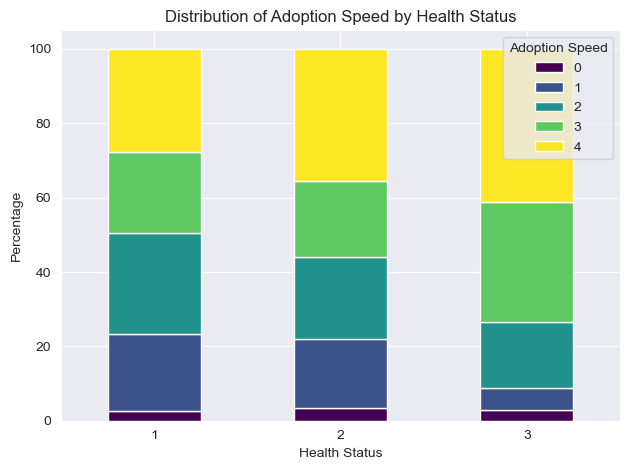

In [78]:
# Group the data by Health and AdoptionSpeed, and calculate the count of each combination
adoption_speed_by_health = pet_train.groupby(['Health', 'AdoptionSpeed']).size().unstack()

# Normalize the counts by the total number of pets with each health status
adoption_speed_by_health_percentage = adoption_speed_by_health.div(adoption_speed_by_health.sum(axis=1), axis=0) * 100

# Plot the bar plot
plt.figure(figsize=(10, 6))
adoption_speed_by_health_percentage.plot(kind='bar', stacked=True, cmap='viridis')

# Add labels and title
plt.title('Distribution of Adoption Speed by Health Status')
plt.xlabel('Health Status')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Adoption Speed')
plt.tight_layout()
plt.show()



The stacked bar plot illustrates a noticeable trend: as the health status of pets deteriorates, the likelihood of slower adoption increases.

### Feature 11 (Vaccincated & Sterilize & Dewormed)

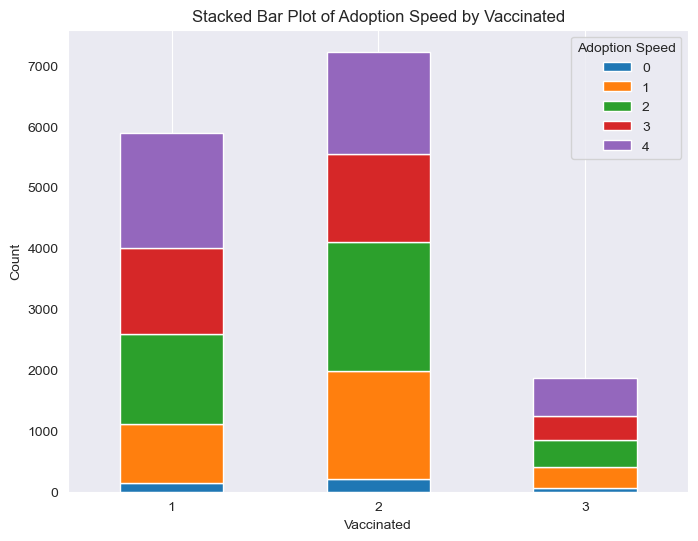

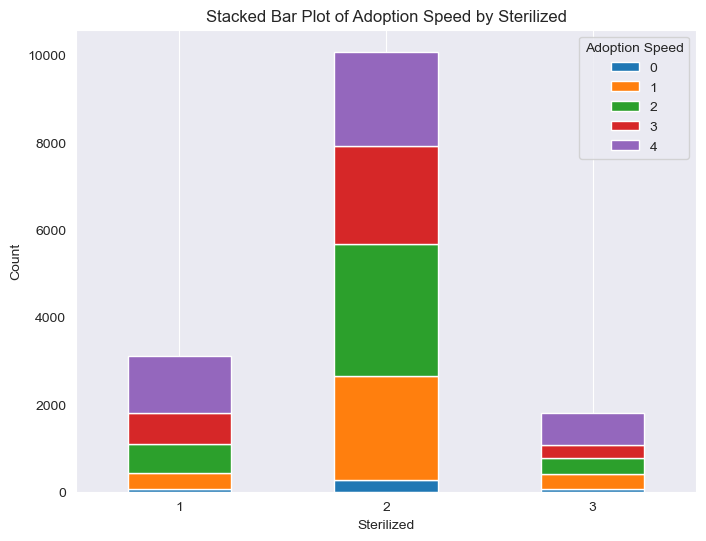

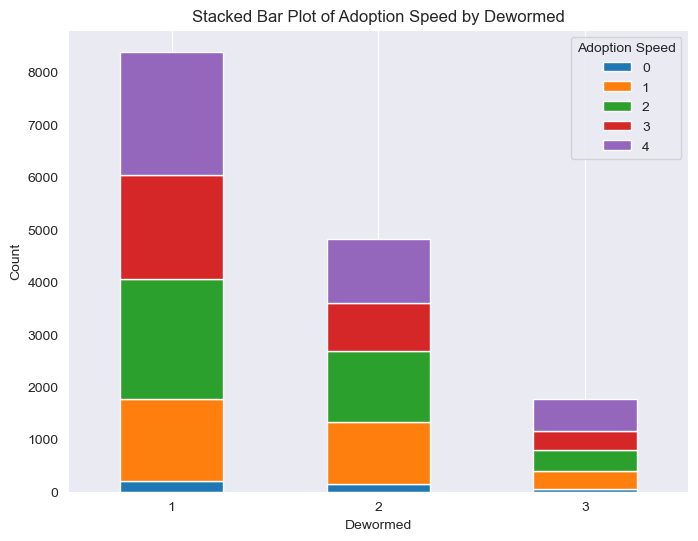

In [79]:
# Define the features
features = ['Vaccinated', 'Sterilized', 'Dewormed']

# Iterate over each feature and create stacked bar plots
for feature in features:
    # Group by the feature and AdoptionSpeed, and calculate the count of each combination
    adoption_speed_by_feature = pet_train.groupby([feature, 'AdoptionSpeed']).size().unstack()
    
    # Plot the stacked bar plot
    adoption_speed_by_feature.plot(kind='bar', stacked=True, figsize=(8, 6))
    
    # Add labels and title
    plt.title(f'Stacked Bar Plot of Adoption Speed by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.legend(title='Adoption Speed')
    plt.grid(axis='y')
    
    # Show the plot
    plt.show()


From the above stack bar plot diagrams, it can been that most of the pet are not vaccinated and sterilize but are dewormed. There appears to be no discernible preference among adopters for pets that are specifically indicated as vaccinated, sterilized, and dewormed

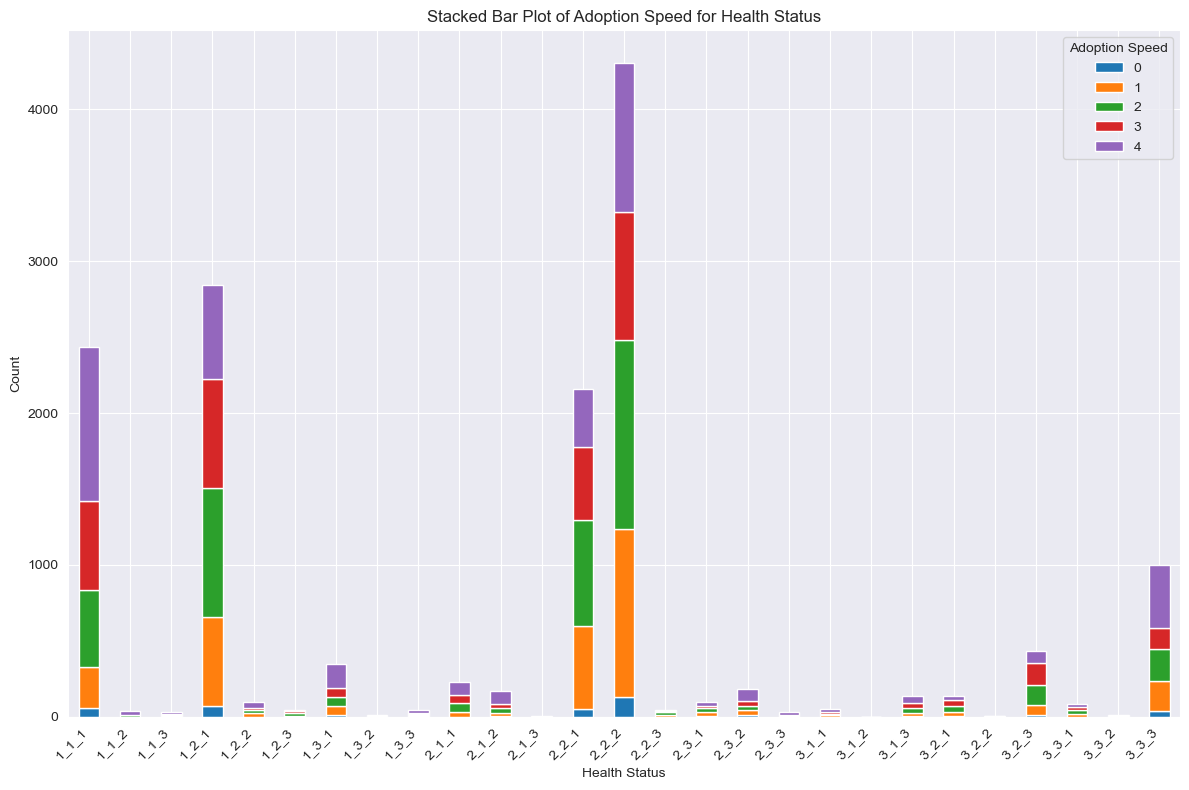

In [80]:
# Combine the values of 'Vaccinated', 'Sterilized', and 'Dewormed' into a new column
pet_train['Health_Status'] = pet_train['Vaccinated'].astype(str) + '_' + pet_train['Sterilized'].astype(str) + '_' + pet_train['Dewormed'].astype(str)

# Group by 'Health_Status' and 'AdoptionSpeed', and calculate the count of each combination
health_status_counts = pet_train.groupby(['Health_Status', 'AdoptionSpeed']).size().unstack(fill_value=0)

# Plot the stacked bar plot
health_status_counts.plot(kind='bar', stacked=True, figsize=(12, 8))

# Add labels and title
plt.title('Stacked Bar Plot of Adoption Speed for Health Status')
plt.xlabel('Health Status')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better readability
plt.legend(title='Adoption Speed')

# Show the plot
plt.tight_layout()
plt.show()


The stacked bar plot highlights a significant observation: the majority of pets are not vaccinated, sterilized, and dewormed, as indicated by the category 2_2_2. This suggests a prevalent trend where adopters do not prioritize these specific health attributes when selecting a pet.

### Feature 12 (Color)

In [81]:
# Concatenate the 'Color1', 'Color2', and 'Color3' columns into a single Series
pet_train_series = pd.concat([pet_train['Color1'], pet_train['Color2'], pet_train['Color3']])

# Exclude color code 0 for cats
pet_train_series = pet_train_series[pet_train_series != 0]

# Count the occurrences of each color for pets and sort them in descending order
pet_color_counts = pet_train_series.value_counts()
pet_color_ranking = pet_color_counts.rank(ascending=False, method='min')

# Map color IDs to color names for pets using the color_labels DataFrame
pet_color_names = pet_color_counts.index.map(color_labels.set_index('ColorID')['ColorName'])

# Print the ranking of colors for pets along with their counts
print("Color Ranking for Pets:")
for color_id, rank in zip(pet_color_counts.index, pet_color_ranking):
    color_name = color_labels[color_labels['ColorID'] == color_id]['ColorName'].iloc[0]
    count = pet_color_counts[color_id]
    print(f"{rank}: {color_name} - {count} pets")

Color Ranking for Pets:
1.0: Black - 7424 pets
2.0: White - 7320 pets
3.0: Brown - 7059 pets
4.0: Cream - 2427 pets
5.0: Gray - 2124 pets
6.0: Golden - 1831 pets
7.0: Yellow - 1702 pets


In [82]:
# Filter the dataset for cats
cat_data = pet_train[pet_train['Type'] == 2]

# Concatenate the 'Color1', 'Color2', and 'Color3' columns into a single Series for cats
cat_colors_series = pd.concat([cat_data['Color1'], cat_data['Color2'], cat_data['Color3']])

# Exclude color code 0 for cats
cat_colors_series = cat_colors_series[cat_colors_series != 0]

# Count the occurrences of each color for cats and sort them in descending order
cat_color_counts = cat_colors_series.value_counts()
cat_color_ranking = cat_color_counts.rank(ascending=False, method='min')

# Map color IDs to color names for cats using the color_labels DataFrame
cat_color_names = cat_color_counts.index.map(color_labels.set_index('ColorID')['ColorName'])

# Print the ranking of colors for cats along with their counts
print("Color Ranking for Cats:")
for color_id, rank in zip(cat_color_counts.index, cat_color_ranking):
    color_name = color_labels[color_labels['ColorID'] == color_id]['ColorName'].iloc[0]
    count = cat_color_counts[color_id]
    print(f"{rank}: {color_name} - {count} pets")

# Filter the dataset for dogs
dog_data = pet_train[pet_train['Type'] == 1]

# Concatenate the 'Color1', 'Color2', and 'Color3' columns into a single Series for dogs
dog_colors_series = pd.concat([dog_data['Color1'], dog_data['Color2'], dog_data['Color3']])

# Exclude color code 0 for dogs
dog_colors_series = dog_colors_series[dog_colors_series != 0]

# Count the occurrences of each color for dogs and sort them in descending order
dog_color_counts = dog_colors_series.value_counts()
dog_color_ranking = dog_color_counts.rank(ascending=False, method='min')

# Map color IDs to color names for dogs using the color_labels DataFrame
dog_color_names = dog_color_counts.index.map(color_labels.set_index('ColorID')['ColorName'])

# Print the ranking of colors for dogs along with their counts
print("\nColor Ranking for Dogs:")
for color_id, rank in zip(dog_color_counts.index, dog_color_ranking):
    color_name = color_labels[color_labels['ColorID'] == color_id]['ColorName'].iloc[0]
    count = dog_color_counts[color_id]
    print(f"{rank}: {color_name} - {count} pets")



Color Ranking for Cats:
1.0: White - 4177 pets
2.0: Black - 3481 pets
3.0: Brown - 2068 pets
4.0: Gray - 1853 pets
5.0: Yellow - 1265 pets
6.0: Golden - 1110 pets
7.0: Cream - 958 pets

Color Ranking for Dogs:
1.0: Brown - 4991 pets
2.0: Black - 3943 pets
3.0: White - 3143 pets
4.0: Cream - 1469 pets
5.0: Golden - 721 pets
6.0: Yellow - 437 pets
7.0: Gray - 271 pets


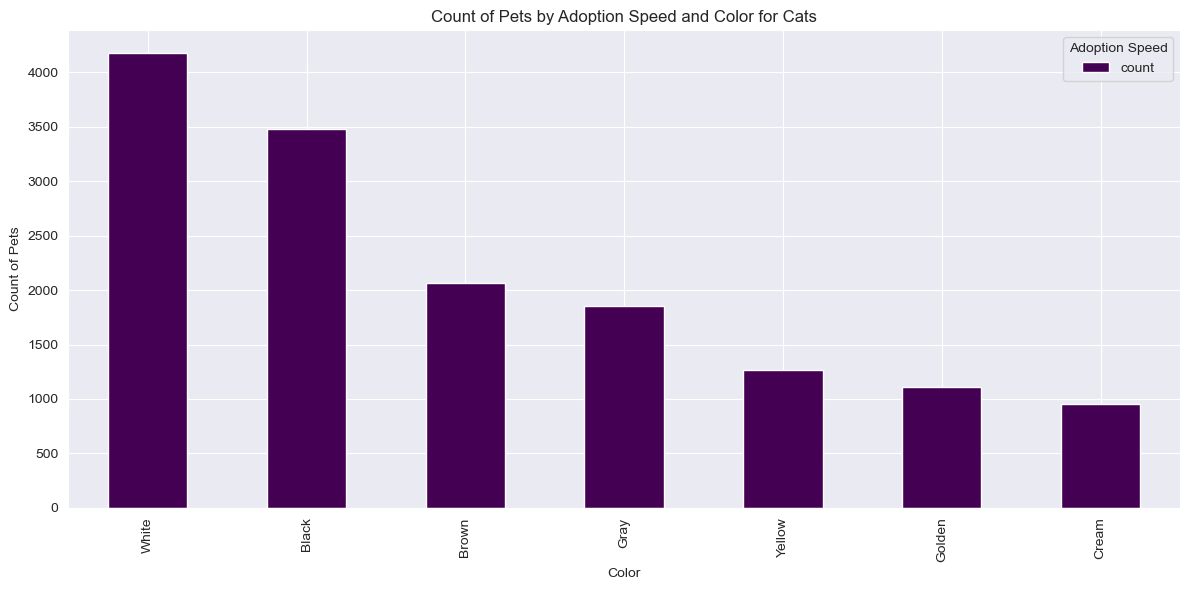

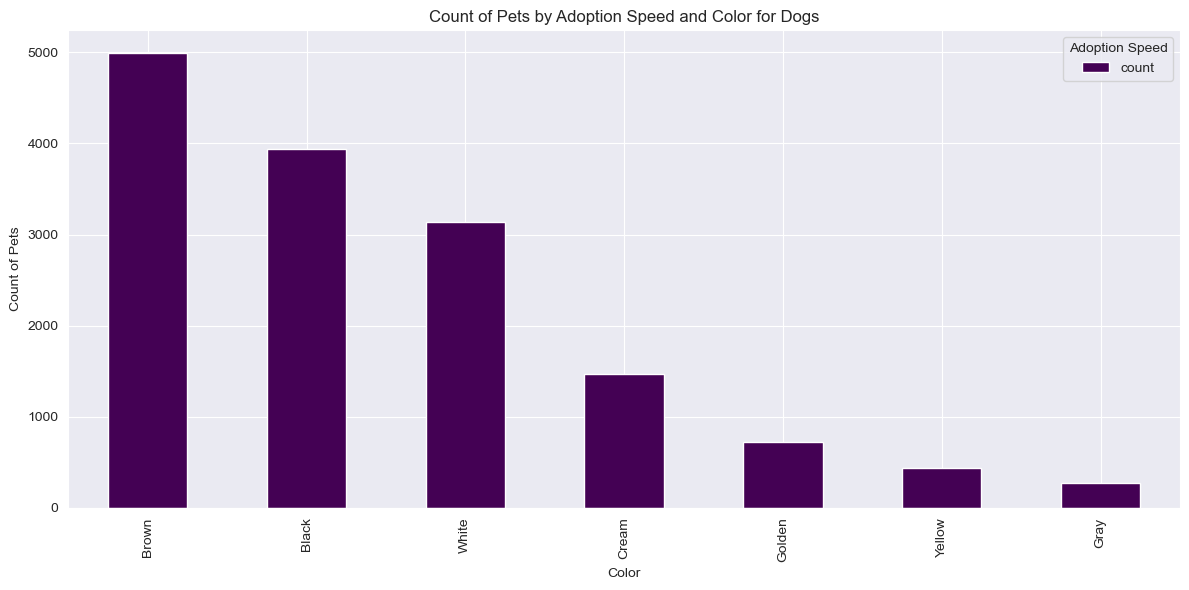

In [83]:
# Function to map color codes to color names
def map_color_names(color_codes):
    return color_codes.map(color_labels.set_index('ColorID')['ColorName'])

# Map color codes to color names for cats
cat_color_names = map_color_names(cat_color_counts.index)

# Plotting for cats
plt.figure(figsize=(12, 6))
cat_color_counts.plot(kind='bar', stacked=True, colormap='viridis')
plt.xlabel('Color')
plt.ylabel('Count of Pets')
plt.title('Count of Pets by Adoption Speed and Color for Cats')
plt.xticks(range(len(cat_color_names)), cat_color_names, rotation=90)
plt.legend(title='Adoption Speed')
plt.tight_layout()
plt.show()

# Map color codes to color names for dogs
dog_color_names = map_color_names(dog_color_counts.index)

# Plotting for dogs
plt.figure(figsize=(12, 6))
dog_color_counts.plot(kind='bar', stacked=True, colormap='viridis')
plt.xlabel('Color')
plt.ylabel('Count of Pets')
plt.title('Count of Pets by Adoption Speed and Color for Dogs')
plt.xticks(range(len(dog_color_names)), dog_color_names, rotation=90)
plt.legend(title='Adoption Speed')
plt.tight_layout()
plt.show()




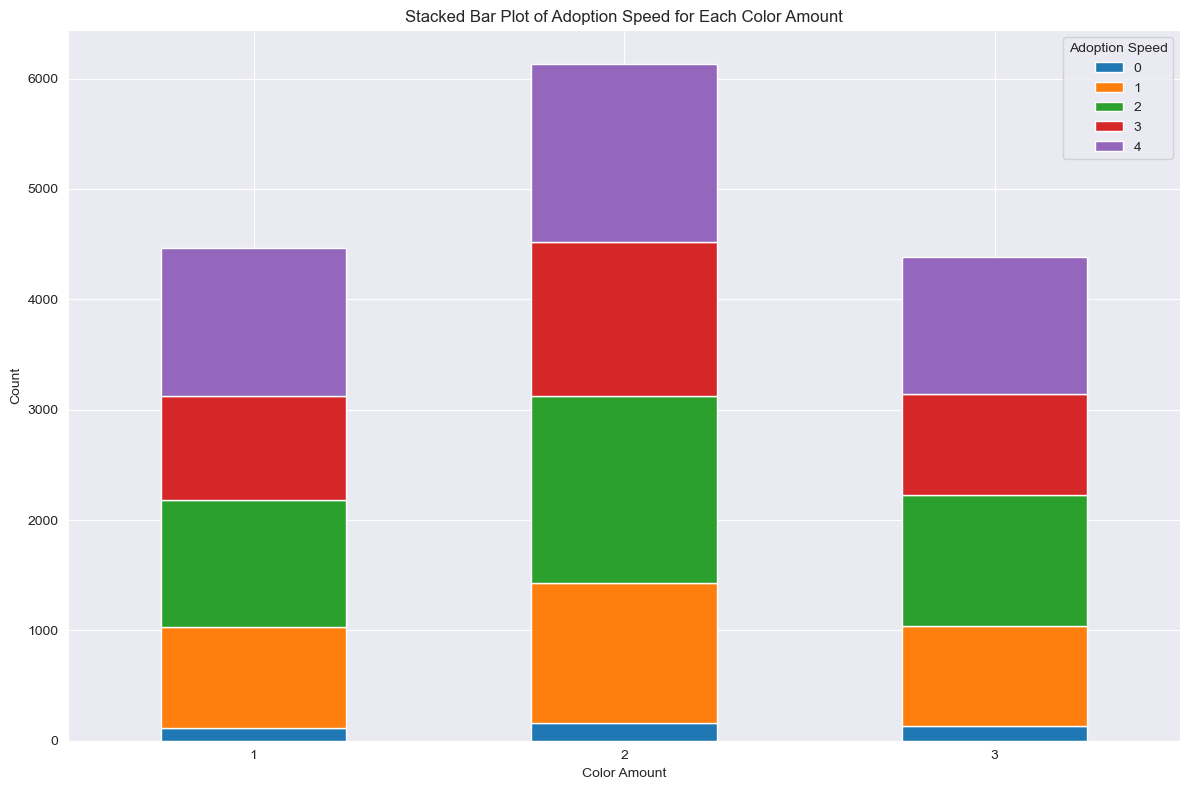

In [84]:
# Group by ColorAmt and AdoptionSpeed
color_amt_counts = pet_train.groupby(['ColorAmt', 'AdoptionSpeed']).size().unstack(fill_value=0)

# Plot the stacked bar plot
color_amt_counts.plot(kind='bar', stacked=True, figsize=(12, 8))

# Add labels and title
plt.title('Stacked Bar Plot of Adoption Speed for Each Color Amount')
plt.xlabel('Color Amount')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-labels if needed
plt.legend(title='Adoption Speed')

# Show the plot
plt.tight_layout()
plt.show()


From the stacked bar plot above, it's evident that the majority of pets have 2 colors. This suggests that there isn't a significant correlation between the number of colors ("ColorAmt") and the adoption speed. In other words, having more or fewer colors doesn't seem to consistently affect how quickly pets are adopted.

### Feature 13 (Description)

In [85]:
def clean_text(text):
    # remove HTML TAG 
    text = re.compile('[<,#*?>]').sub(r'',text) 
    # Remove urls: 
    text = re.compile('https?://\S+|www\.S+').sub(r'',text)
    # Remove email id:
    text = re.compile('[A-Za-z0-2]+@[\w]+.[\w]+').sub(r'',text) 
    # Remove accented characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Remove punctuation
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    # Remove irrelevant characters
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Remove extra whitespaces
    text = re.sub(r'^\s*|\s\s*', ' ', text).strip()
    # Convert to lowercase
    text = text.lower()
    return text

# Apply the combined function to pet_train['Description']
pet_train['Description'] = pet_train['Description'].apply(clean_text)


In [86]:
# Function to detect the presence of Chinese characters in a text
def contains_chinese(text):
    chinese_pattern = re.compile(r'[\u4e00-\u9fff]')  # Chinese characters Unicode range
    return 1 if chinese_pattern.search(text) else 0

# Create a new column 'ContainsChinese' indicating whether the description contains Chinese
pet_train['ContainsChinese'] = pet_train['Description'].apply(lambda x: contains_chinese(str(x)))


In [87]:
# Initialize the translator
translator = Translator()

# Translate descriptions containing Chinese to English
pet_train.loc[pet_train['ContainsChinese'] == 1, 'Description'] = pet_train[pet_train['ContainsChinese'] == 1]['Description'].apply(lambda x: translator.translate(x, dest='en').text)

# Display the translated descriptions
print(pet_train[pet_train['ContainsChinese'] == 1]['Description'])

Series([], Name: Description, dtype: object)


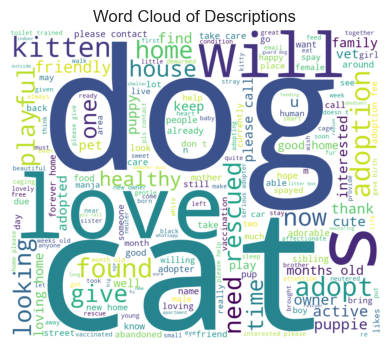

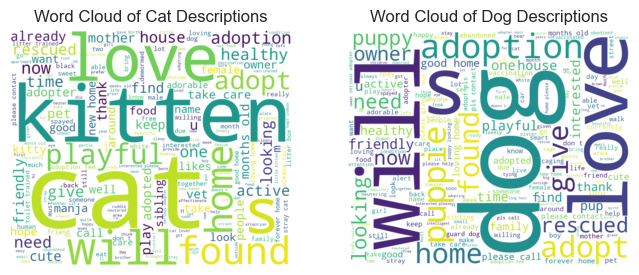

In [88]:
# Filter descriptions for cat and dog data
cat_descriptions = ' '.join(pet_train[pet_train['Type'] == 2]['Description'].fillna('').values)
dog_descriptions = ' '.join(pet_train[pet_train['Type'] == 1]['Description'].fillna('').values)
# Concatenate all descriptions into a single string
all_descriptions = ' '.join(pet_train['Description'].fillna('').values)


# Generate word clouds for cat and dog descriptions
cat_wordcloud = WordCloud(max_font_size=None, background_color='white',
                          width=1200, height=1000).generate(cat_descriptions)
dog_wordcloud = WordCloud(max_font_size=None, background_color='white',
                          width=1200, height=1000).generate(dog_descriptions)
# Generate word cloud
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(all_descriptions)

# Display the word cloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Descriptions')
plt.axis("off")
plt.show()

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(cat_wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Cat Descriptions')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(dog_wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Dog Descriptions')
plt.axis("off")

plt.show()


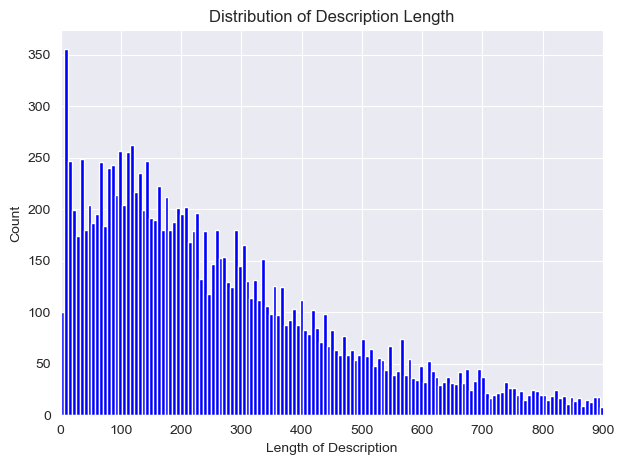

In [89]:
# Calculate the length of each description
description_lengths = [len(text) for text in pet_train['Description'].values.tolist()]

# Plot the distribution of description lengths
plt.figure(figsize=(7, 5))
plt.hist(description_lengths, bins=1000, color='blue')
plt.title('Distribution of Description Length')
plt.xlabel('Length of Description')
plt.ylabel('Count')
plt.xlim(0, 900)
plt.show()


In [90]:
pet_train['DescriptionLength'] = pet_train['Description'].str.len()

In [91]:
empty_description_rows = pet_train[pet_train['Description'].str.len() == 1]
empty_description_rows

,PetID,AdoptionSpeed,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,...,BreedID,BreedName_BreedLabels,AgeGroup,AgeCategory,Type_label,PhotoAmt_Adjusted,Free,Health_Status,ContainsChinese,DescriptionLength


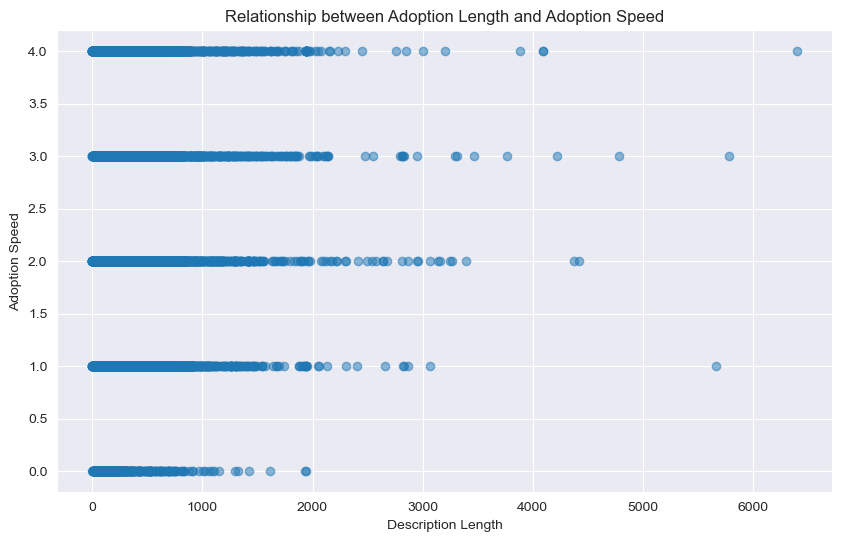

In [92]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(pet_train['DescriptionLength'], pet_train['AdoptionSpeed'], alpha=0.5)
plt.title('Relationship between Adoption Length and Adoption Speed')
plt.xlabel('Description Length')
plt.ylabel('Adoption Speed')
plt.grid(True)
plt.show()


In [93]:
# Function to get sentiment polarity of a text
def get_sentiment(text):
    blob = TextBlob(str(text))
    return blob.sentiment.polarity

# Create a new column 'DescriptionSentiment' and calculate sentiment polarity for each description
pet_train['DescriptionSentiment'] = pet_train['Description'].apply(get_sentiment)

# Display the DataFrame with the new column
print(pet_train.head())


       PetID  AdoptionSpeed  Type     Name  Age Breed1  Breed2  Gender  \
0  86e1089a3              2     2   Nibble    3    299       0       1   
1  6296e909a              0     2  No Name    1    265       0       1   
2  3422e4906              3     1   Brisco    1    307       0       1   
3  5842f1ff5              2     1     Miko    4    307       0       2   
4  850a43f90              2     1   Hunter    1    307       0       1   

   Color1  Color2  ...  BreedName_BreedLabels  AgeGroup  AgeCategory  \
0       1       7  ...                  Tabby    [3, 6)            2   
1       1       2  ...   Domestic Medium Hair    [0, 2)            0   
2       2       7  ...            Mixed Breed    [0, 2)            0   
3       1       2  ...            Mixed Breed    [3, 6)            2   
4       1       0  ...            Mixed Breed    [0, 2)            0   

   Type_label  PhotoAmt_Adjusted  Free  Health_Status  ContainsChinese  \
0         Cat                  1     0          

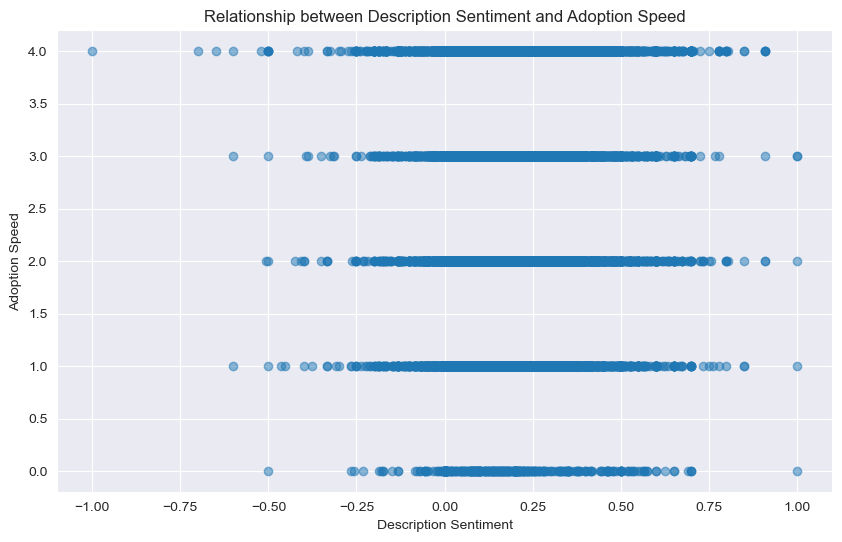

In [94]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(pet_train['DescriptionSentiment'], pet_train['AdoptionSpeed'], alpha=0.5)
plt.title('Relationship between Description Sentiment and Adoption Speed')
plt.xlabel('Description Sentiment')
plt.ylabel('Adoption Speed')
plt.show()


In [95]:
# Filter the DataFrame to include only rows where Description Sentiment is below 0
negative_sentiment_data = pet_train[pet_train['DescriptionSentiment'] < -0.25]

# Calculate the correlation coefficient
correlation_negative_sentiment = negative_sentiment_data['DescriptionSentiment'].corr(pet_train['AdoptionSpeed'])

print("Correlation coefficient between Description Sentiment (below 0) and Adoption Speed:", correlation_negative_sentiment)


Correlation coefficient between Description Sentiment (below 0) and Adoption Speed: -0.22284421852835545


Based on the scatter plot, there appears to be a correlation suggesting that pets with lower Description Sentiment starting from 0.25 tend to experience slower adoption rates.

### Dropping Irrelevant Columns

In [96]:
pet_train = pet_train.dropna()

In [97]:
pet_train = pet_train.astype({'Breed1': int,'AgeCategory': int})

In [98]:
pet_train['NameorNO'] = pet_train['NameorNO'].map({'Y': 1, 'N': 0})


Columns with non-numeric data: Index(['PetID', 'Name', 'RescuerID', 'Description', 'AgeBins', 'FeeBins',
       'BreedBins', 'StateBins', 'VideoAmtBins', 'PhotoAmtBins',
       'QuantityBins', 'TypeName', 'GenderName', 'MaturitySizeName',
       'FurLengthName', 'HealthName', 'VaccinatedName', 'DewormedName',
       'SterilizedName', 'BreedName', 'BreedBinsName', 'StateName',
       'StateBinsName', 'ColorName', 'AdoptedName', 'BreedName_BreedLabels',
       'AgeGroup', 'Type_label', 'Health_Status'],
      dtype='object')


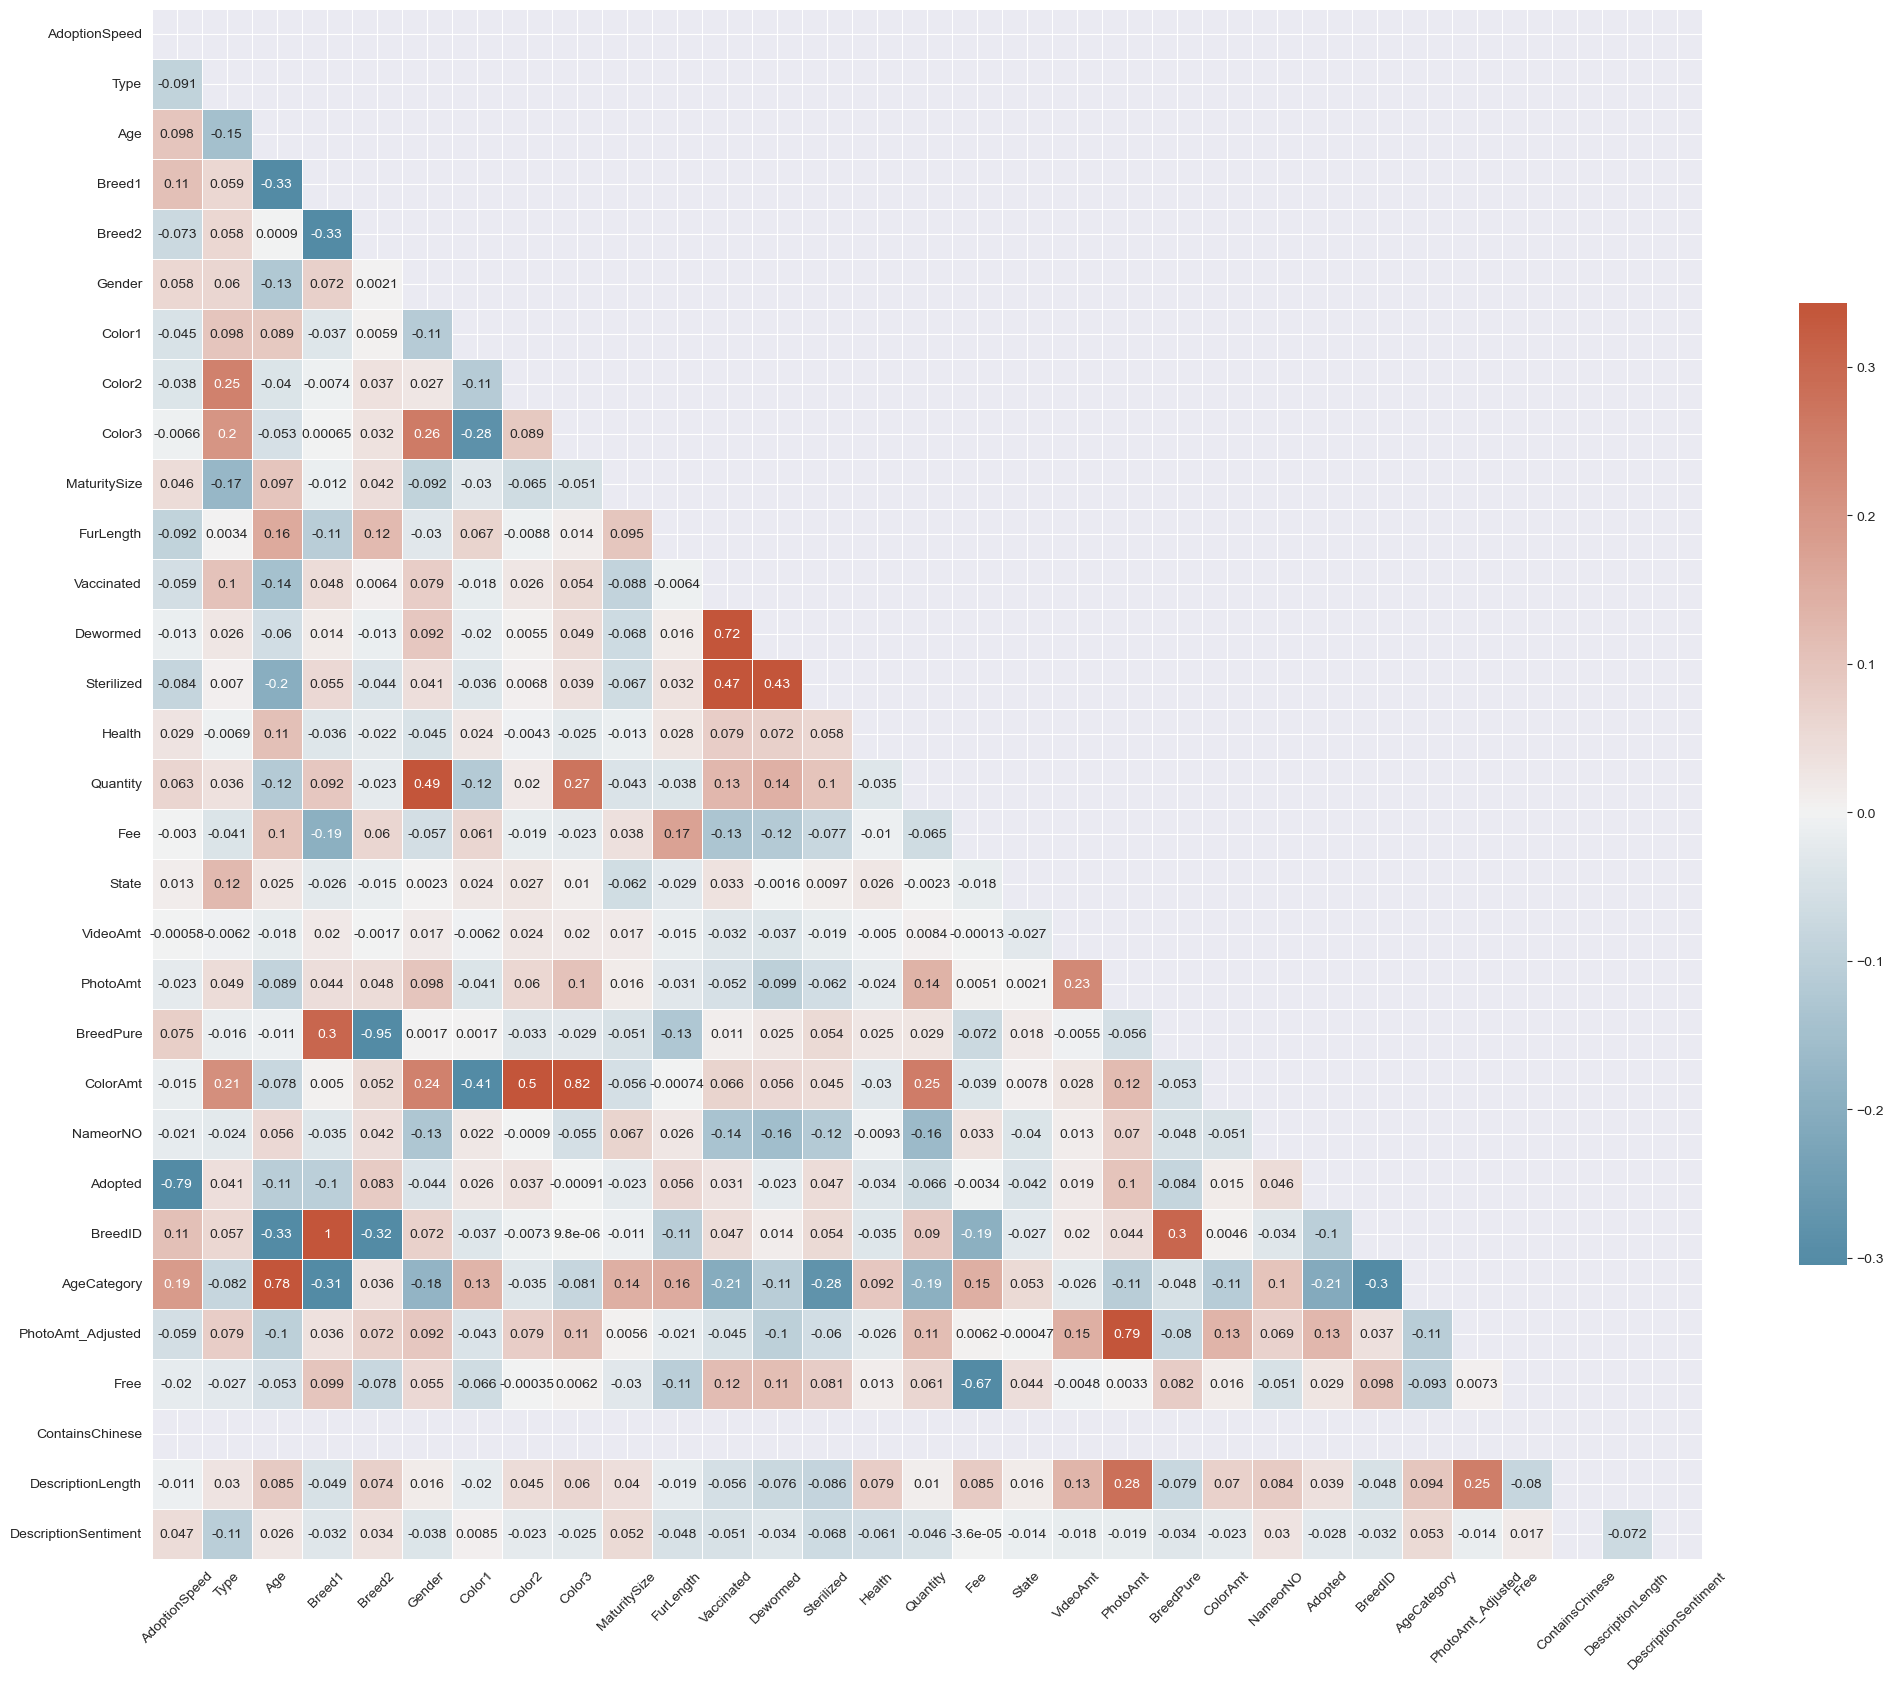

In [99]:
def heatmap():
    # Identify columns with non-numeric data
    non_numeric_columns = pet_train.select_dtypes(exclude=['number']).columns
    print("Columns with non-numeric data:", non_numeric_columns)

    # Convert non-numeric columns to numeric if possible
    # For example, if 'Name' column is causing the issue, you might want to exclude it
    pet_train_numeric = pet_train.drop(columns=non_numeric_columns)

    # Compute correlation matrix
    corr = pet_train_numeric.corr()

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Plot correlation heatmap
    f, ax = plt.subplots(figsize=(25, 25))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=0.5,
                cbar_kws={"shrink": 0.5}, annot=True, robust=True)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.show()
heatmap()

In [100]:
pet_train = pet_train.drop(['PetID', 'Name','RescuerID',
       'FeeBins', 'BreedBins', 'StateBins', 'VideoAmtBins',
        'TypeName', 'GenderName',
       'MaturitySizeName', 'FurLengthName', 'HealthName', 'VaccinatedName',
       'DewormedName', 'SterilizedName', 'BreedName', 'BreedBinsName',
       'StateName', 'StateBinsName', 'ColorName', 'AdoptedName',
       'BreedName_BreedLabels', 'BreedName_BreedLabels', 'AgeGroup',
       'Type_label', 'Health_Status','ContainsChinese',
        'BreedID','ColorAmt','VideoAmt','Fee','Dewormed',
        'Sterilized','Vaccinated','Breed2','AgeBins','PhotoAmtBins', 
        'QuantityBins','Adopted','DescriptionLength','Age','PhotoAmt',
        'Color2','Color3','Description'], axis='columns')

The decision to remove these columns from the dataset was based on several considerations:

Irrelevance: These columns were deemed irrelevant to the analysis or prediction task at hand. For instance, columns like 'PetID', 'Name', and 'RescuerID' don't provide meaningful insights into the factors influencing pet adoption.

Redundancy: Certain columns like FeeBins', 'BreedBins', 'StateBins' contained redundant information. Including redundant features adds noise to the dataset and may hinder the performance of machine learning models.

Preprocessing: During data preprocessing, some columns were transformed or merged into other features. As a result, the original columns became redundant e.g 'Age','PhotoAmt' and were removed to avoid duplication.

By eliminating these columns, the dataset is streamlined to focus on the most informative and relevant features, which can improve the efficiency and effectiveness of subsequent analysis and modeling tasks.

In [101]:
pet_train.columns

Index(['AdoptionSpeed', 'Type', 'Breed1', 'Gender', 'Color1', 'MaturitySize',
       'FurLength', 'Health', 'Quantity', 'State', 'BreedPure', 'NameorNO',
       'AgeCategory', 'PhotoAmt_Adjusted', 'Free', 'DescriptionSentiment'],
      dtype='object')

Columns with non-numeric data: Index([], dtype='object')


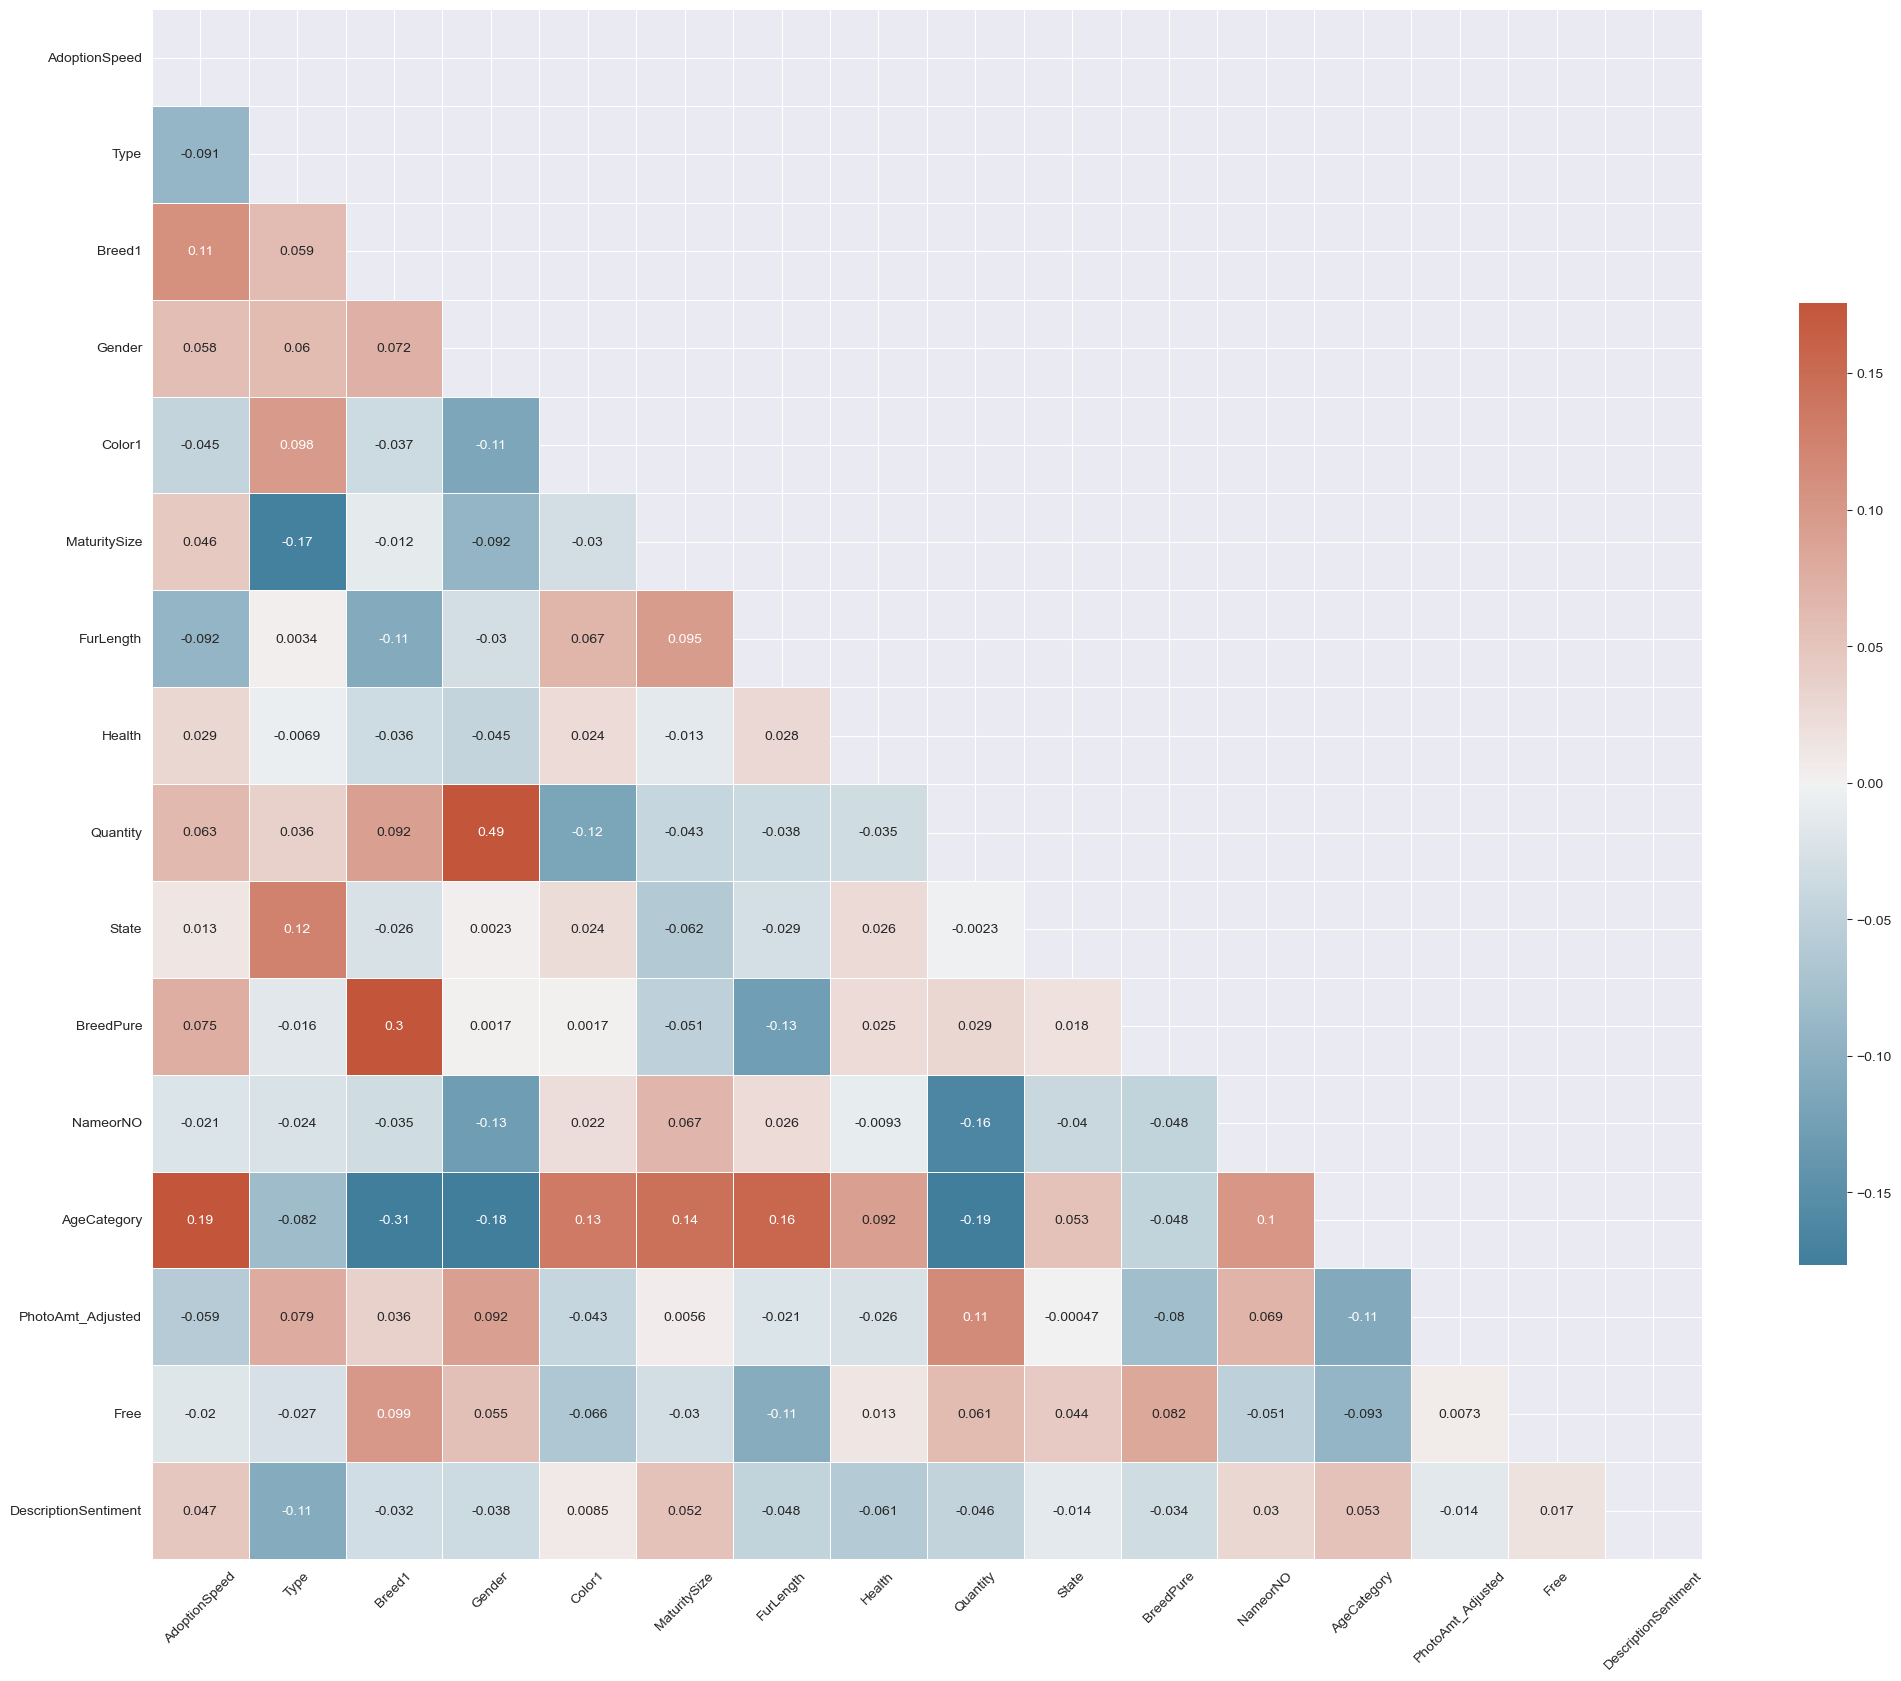

In [102]:
heatmap()

### Models

In [103]:
X = pet_train.drop(['AdoptionSpeed'], axis = 1)
y = pet_train.AdoptionSpeed

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print("Train")
print("##############")
print('X Features Shape:', X_train.shape)
print('y Labels Shape:', y_train.shape)
print("Test")
print("##############")
print('X Features Shape:', X_test.shape)
print('y Labels Shape:', y_test.shape)

Train
##############
X Features Shape: (11237, 15)
y Labels Shape: (11237,)
Test
##############
X Features Shape: (3746, 15)
y Labels Shape: (3746,)


### Naive Bayes

In [104]:
start = timer()
# Instantiate the Gaussian Naive Bayes model
model_nb = GaussianNB()

# Fit the model to the training data
model_nb.fit(X_train, y_train)

# Predict on the test data
y_prediction_nb = model_nb.predict(X_test)

# Calculate accuracy scores
train_accuracy_nb = model_nb.score(X_train, y_train)
test_accuracy_nb = model_nb.score(X_test, y_test)
end = timer()
# Print the accuracy scores
print("Naive Bayes train accuracy: {:.2f}%".format(train_accuracy_nb * 100))
print("Naive Bayes test accuracy: {:.2f}%".format(test_accuracy_nb * 100))


Naive Bayes train accuracy: 35.24%
Naive Bayes test accuracy: 36.65%


In [105]:
# Fit Model Time
print("Naive Bayes Model Time Taken: {} minutes".format(round((end-start)/60, 2)))
# Perform cross-validation
cv_scores = cross_val_score(model_nb, X, y, cv=5)

# Calculate mean score and confidence interval
mean_accuracy = cv_scores.mean()
confidence_interval = cv_scores.std() * 2
print("Accuracy: {:.2f} (+/- {:.2f})".format(mean_accuracy, confidence_interval))

# Calculate Cohen's kappa score
kappa_score = cohen_kappa_score(y_test, y_prediction_nb, weights="quadratic")
print("Cohen's Kappa Score:", kappa_score)


Naive Bayes Model Time Taken: 0.0 minutes
Accuracy: 0.35 (+/- 0.01)
Cohen's Kappa Score: 0.2687531269085245


### KNeighborsClassifier

In [106]:
# Define a range of n_neighbors values to try
param_grid = {'n_neighbors': range(1, 21)}  # Trying values from 1 to 20

# Initialize the KNeighborsClassifier
model_knc = KNeighborsClassifier()

# Use GridSearchCV to search for the best n_neighbors
grid_search = GridSearchCV(model_knc, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best n_neighbors value
best_n_neighbors = grid_search.best_params_['n_neighbors']

# Print the best n_neighbors value
print("Best n_neighbors:", best_n_neighbors)


Best n_neighbors: 20


In [107]:
# Choose the number of neighbors
n_neighbors = 20

start = timer()
# Initialize the KNeighborsClassifier
model_knc = KNeighborsClassifier(n_neighbors=n_neighbors)

# Fit the model to the training data
model_knc.fit(X_train, y_train)

# Make predictions on the test data
y_prediction_knc = model_knc.predict(X_test)

# Calculate accuracy scores
train_accuracy_knc = model_knc.score(X_train, y_train)
test_accuracy_knc = model_knc.score(X_test, y_test)
end = timer()
# Print the accuracy scores
print("KNeighbors Classifier train accuracy: {:.2f}%".format(train_accuracy_knc * 100))
print("KNeighbors Classifier test accuracy: {:.2f}%".format(test_accuracy_knc * 100))



KNeighbors Classifier train accuracy: 43.81%
KNeighbors Classifier test accuracy: 35.42%


In [108]:
# Fit Model Time
print("KNeighbors Model Time Taken: {} minutes".format(round((end-start)/60, 2)))
# Perform cross-validation
cv_scores = cross_val_score(model_knc, X, y, cv=5)

# Calculate mean score and confidence interval
mean_accuracy = cv_scores.mean()
confidence_interval = cv_scores.std() * 2
print("Accuracy: {:.2f} (+/- {:.2f})".format(mean_accuracy, confidence_interval))

# Calculate Cohen's kappa score
kappa_score = cohen_kappa_score(y_test, y_prediction_knc, weights="quadratic")
print("Cohen's Kappa Score:", kappa_score)


KNeighbors Model Time Taken: 0.05 minutes
Accuracy: 0.35 (+/- 0.02)
Cohen's Kappa Score: 0.2738150522573142


### XGBOOST

In [109]:
# Define a range of n_estimators values to try
param_grid = {
    'n_estimators': [10, 20, 30, 50, 70, 100]
}

# Instantiate the XGBClassifier
model_xg = xgb.XGBClassifier(objective='binary:logistic', seed=123)

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=model_xg, param_grid=param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameter values
best_params = grid_search.best_params_

# Print the best parameter values
print("Best n_estimators:", best_params['n_estimators'])


Best n_estimators: 10


In [110]:
start = timer()
# Instantiate the XGBClassifier: xg_cl
model_xg = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)

# Fit the classifier to the training set
model_xg.fit(X_train,y_train)

# Predict the labels of the test set: preds
y_prediction_xg = model_xg.predict(X_test)

# accuracy score
train_accuracy_xgb = model_xg.score(X_train, y_train)
test_accuracy_xgb = model_xg.score(X_test, y_test)
end = timer()
print("XGBOOST Train accuracy: {:.2f}%".format(train_accuracy_xgb * 100))
print("XGBOOST Classifier test accuracy: {:.2f}%".format(test_accuracy_xgb * 100))

XGBOOST Train accuracy: 47.69%
XGBOOST Classifier test accuracy: 38.71%


In [111]:
# Fit Model Time
print("XGBOOST Model Time Taken: {} minutes".format(round((end-start)/60, 2)))

# Perform cross-validation
cv_scores = cross_val_score(model_xg, X, y, cv=5)

# Calculate mean score and confidence interval
mean_accuracy = cv_scores.mean()
confidence_interval = cv_scores.std() * 2
print("Accuracy: {:.2f} (+/- {:.2f})".format(mean_accuracy, confidence_interval))

# Calculate Cohen's kappa score
kappa_score = cohen_kappa_score(y_test, y_prediction_xg, weights="quadratic")
print("Cohen's Kappa Score:", kappa_score)


XGBOOST Model Time Taken: 0.0 minutes
Accuracy: 0.39 (+/- 0.00)
Cohen's Kappa Score: 0.31437092924092136


### Logistic Regression

In [112]:
pet_train.columns

Index(['AdoptionSpeed', 'Type', 'Breed1', 'Gender', 'Color1', 'MaturitySize',
       'FurLength', 'Health', 'Quantity', 'State', 'BreedPure', 'NameorNO',
       'AgeCategory', 'PhotoAmt_Adjusted', 'Free', 'DescriptionSentiment'],
      dtype='object')

In [113]:
start = timer()
# Define numeric features and transformer
numeric_features = ['AgeCategory', 'PhotoAmt_Adjusted', 'Quantity']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define categorical features and transformer
categorical_features = ['Type', 'Gender', 'MaturitySize', 'FurLength', 'Free',
                        'Health', 'Breed1', 'Color1', 'DescriptionSentiment','State']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create preprocessor pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Instantiate model with preprocessor
model_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=15000))
])

# Fit model to training data
model_lr.fit(X_train, y_train)

# Make predictions on test data
y_prediction_lr = model_lr.predict(X_test)

# Calculate accuracy scores
train_accuracy_lr = model_lr.score(X_train, y_train)
test_accuracy_lr = model_lr.score(X_test, y_test)
end=timer()
print("Logistic Regression train accuracy: {:.2f}%".format(train_accuracy_lr * 100))
print("Logistic Regression test accuracy: {:.2f}%".format(test_accuracy_lr * 100))

Logistic Regression train accuracy: 66.70%
Logistic Regression test accuracy: 39.22%


In [114]:
# Fit Model Time
print("Logistic Regression Time Taken: {} minutes".format(round((end-start)/60, 2)))
# Perform cross-validation
cv_scores = cross_val_score(model_lr, X, y, cv=5)

# Calculate mean score and confidence interval
mean_accuracy = cv_scores.mean()
confidence_interval = cv_scores.std() * 2
print("Accuracy: {:.2f} (+/- {:.2f})".format(mean_accuracy, confidence_interval))

# Calculate Cohen's kappa score
kappa_score = cohen_kappa_score(y_test, y_prediction_lr, weights="quadratic")
print("Cohen's Kappa Score:", kappa_score)

Logistic Regression Time Taken: 0.07 minutes
Accuracy: 0.39 (+/- 0.01)
Cohen's Kappa Score: 0.33538300731576


In [115]:
# Define the parameter grid
param_grid = {
    'classifier__C': [0.1],  # Regularization parameter
    'classifier__penalty': ['l2'],  # Penalty term ('l2' for Ridge)
    'classifier__solver': ['sag', 'saga']  # Optimization algorithm
}

# Instantiate logistic regression model with increased max_iter
model_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=10000))
])

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model_lr, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Test the model with the best parameters
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy with Best Parameters: {:.2f}%".format(test_accuracy * 100))


Fitting 3 folds for each of 2 candidates, totalling 6 fits
Test Accuracy with Best Parameters: 39.40%


### Random Forest Classifier

In [116]:
# Instantiate Random Forest model with preprocessor
model_1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_jobs=-1, n_estimators=300,random_state=1243))
])

# Fit model to training data
model_1.fit(X_train, y_train)

# Make predictions on test data
y_model_randomforest = model_1.predict(X_test)

# Calculate accuracy scores
train_accuracy_rf = model_1.score(X_train, y_train)
test_accuracy_rf = model_1.score(X_test, y_test)
print("Random Forest train accuracy: {:.2f}%".format(train_accuracy_rf * 100))
print("Random Forest test accuracy: {:.2f}%".format(test_accuracy_rf * 100))


Random Forest train accuracy: 99.02%
Random Forest test accuracy: 38.81%


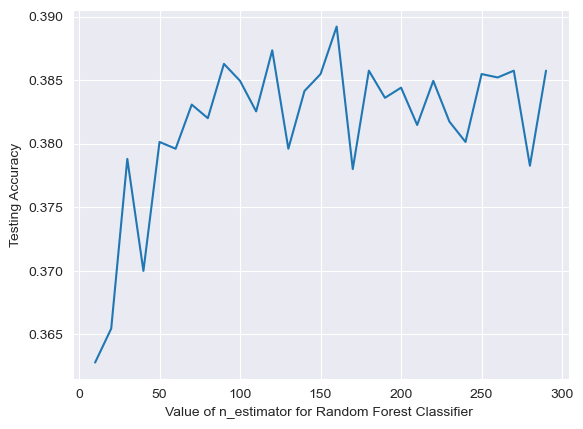

In [117]:
model = RandomForestClassifier(n_jobs=-1) #Run all processor

# Try different numbers of n_estimators
estimators = np.arange(10, 300, 10)
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))

plt.xlabel("Value of n_estimator for Random Forest Classifier ")
plt.ylabel("Testing Accuracy")
plt.plot(estimators, scores)

In [118]:
start = timer()
# Instantiate the RandomForestClassifier model
model_rf = RandomForestClassifier(n_estimators=150)

# Fit the model to the training data
model_rf.fit(X_train, y_train)

# Make predictions on the test data
y_prediction_rf = model_rf.predict(X_test)

# Calculate accuracy scores
train_accuracy_randomforest = model_rf.score(X_train, y_train)
test_accuracy_randomforest = model_rf.score(X_test, y_test)
end = timer()
# Print the accuracy scores
print("Random Forest Train Accuracy: {:.2f}%".format(train_accuracy_randomforest * 100))
print("Random Forest Test Accuracy: {:.2f}%".format(test_accuracy_randomforest * 100))


Random Forest Train Accuracy: 99.13%
Random Forest Test Accuracy: 38.71%


In [119]:
# Fit Model Time
print("Random Forest Time Taken: {} minutes".format(round((end-start)/60, 2)))
# Perform cross-validation
cv_scores = cross_val_score(model_rf, X, y, cv=5)

# Calculate mean score and confidence interval
mean_accuracy = cv_scores.mean()
confidence_interval = cv_scores.std() * 2
print("Accuracy: {:.2f} (+/- {:.2f})".format(mean_accuracy, confidence_interval))

# Calculate Cohen's kappa score
kappa_score = cohen_kappa_score(y_test, y_prediction_rf, weights="quadratic")
print("Cohen's Kappa Score:", kappa_score)

Random Forest Time Taken: 0.06 minutes
Accuracy: 0.39 (+/- 0.01)
Cohen's Kappa Score: 0.31590439509599455


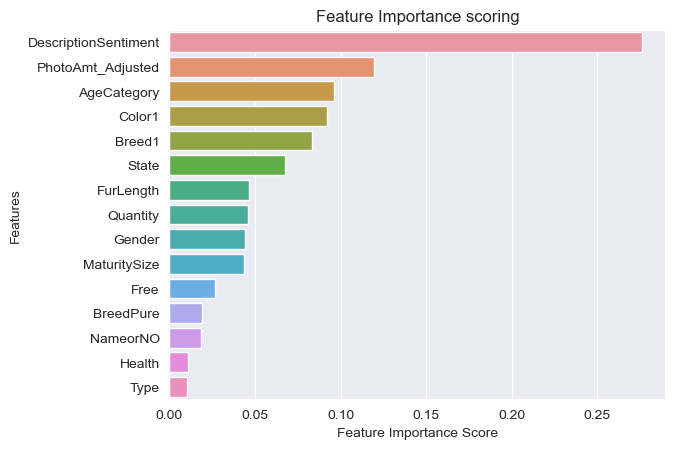

In [120]:
features = pd.Series(model_rf.feature_importances_,index=X.columns).sort_values(ascending=False)
sns.barplot(x=features, y=features.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importance scoring")
plt.show()

In [121]:
import random
# Define the parameter grid
param_grid = {
    'bootstrap': [True],
    'max_depth': [120, 140, 150, 160],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [150, 200]
}

# Create the base model
rf_model = RandomForestClassifier(random_state=1243)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X, y)

# Get the best parameters
best_params = grid_search.best_params_
best_params


Fitting 3 folds for each of 72 candidates, totalling 216 fits


{'bootstrap': True,
 'max_depth': 120,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 200}

In [122]:
# Get the best estimator from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred_test = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

# Calculate accuracy
train_accuracy_rf = accuracy_score(y_train, y_pred_train)
test_accuracy_rf = accuracy_score(y_test, y_pred_test)

# Print the accuracies
print("Random Forest Train Accuracy: ", train_accuracy_rf)
print("Random Forest Test Accuracy: ", test_accuracy_rf)


Random Forest Train Accuracy:  0.7349826466138649
Random Forest Test Accuracy:  0.7277095568606513


In [123]:
kappa_score = cohen_kappa_score(y_test, y_pred_test, weights = "quadratic")
print("Cohen's Kappa Score:", kappa_score)

Cohen's Kappa Score: 0.6456559217470716


In [124]:
random_state_used = rf_model.random_state
print("Random state seed used by RandomForestClassifier:", random_state_used)


Random state seed used by RandomForestClassifier: 1243


Cohen's Kappa Score:

Naive Bayes Model: 0.2687531269085245

KNeighbors Model: 0.2738150522573142

XGBOOST Model: 0.31437092924092136

Logistic Regression: 0.33538300731576

Random Forest: 0.6456559217470716

Best Model: Random Forest